**Introduction**


**Objective**: Build an explainable regression model to estimate expected loan loss using pre-origination borrower and loan features.

The project aims to predict the expected financial loss on a loan, based on borrower attributes, loan characteristics, and credit behaviour in the historical Lending Club dataset. The focus is on building an explainable model that helps lenders understand which factors most strongly influence credit risk and how these factors affect expected loss.

The primary target is the expected loss. Although the modelling framework could be extended to predict the probability of default,modelling the loss_amount captures the severity of the projected loss which is more actionable for lending decisions.



## Import required packages

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt
import shap

import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from google.colab import data_table

import warnings
warnings.filterwarnings("ignore")

#pio.renderers.default = 'notebook_connected'
pio.renderers.default = 'png'

In [3]:
#!pip install -U kaleido==0.2.1

### Data Overview


The project uses the Lending Club Accepted Loan Dataset a publicly available dataset containing millions of consumer loan records from 2007 - 2018. The dataset includes borrower demographics, loan characteristics, and credit bureau information.

Only pre-origination features were retained to prevent data leakage and ensure that predictions reflect information available at the time of the lending decision.


In [4]:
#Initial data load and checks
#Load the whole dataset 2M + records  151 cols
df_raw = pd.read_csv("/content/drive/MyDrive/Berkeley/capstone/data/accepted_2007_to_2018Q4.csv", low_memory=False)

In [5]:
#create a working copy
df = df_raw.copy()

In [6]:
# Commented out to keep notebook concise
#df.sample(5)

In [7]:
print(df.shape)
df.dtypes.value_counts()

(2260701, 151)


,count
float64,113
object,38


The dataset consists of 2.26M rows and 151 features, predominantly numeric, with a smaller set of categorical variables

## Exploratory data analysis

In [8]:
# Transpose stats for feature comparison
#df.describe(include="all").T.sort_values("count", ascending=False).round(2)

desc = df.describe(include="all").T
desc_sorted = desc.sort_values("count", ascending=False)

# display a compact view
pd.concat([desc_sorted.head(5), desc_sorted.tail(5)]).round(2)



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2260701,2260701,Total amount funded in policy code 2: 521953170,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_pymnt_inv,2260668.0,NaN,NaN,NaN,12064.394655,9896.991745,0.0,4531.8,9309.675,16916.705,63296.88
fico_range_high,2260668.0,NaN,NaN,NaN,702.5884,33.011245,614.0,679.0,694.0,719.0,850.0
disbursement_method,2260668,2,Cash,2182546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_flag,2260668,2,N,2259836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_amount,10917.0,NaN,NaN,NaN,155.045981,129.040594,0.64,59.44,119.14,213.26,943.94
deferral_term,10917.0,NaN,NaN,NaN,3.0,0.0,3.0,3.0,3.0,3.0,3.0
hardship_status,10917,3,COMPLETED,7819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orig_projected_additional_accrued_interest,8651.0,NaN,NaN,NaN,454.798089,375.3855,1.92,175.23,352.77,620.175,2680.89
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#check for duplicates
print("Total duplicates:", df.duplicated().sum())
print("Duplicate loan Ids:", df["id"].duplicated().sum())


Total duplicates: 0
Duplicate loan Ids: 0


There are no duplicate records

In [10]:
# Load the Lending Club data dictionary to map feature definitions and EDA categories
# EDA categories were assigned after manual review of feature definitions:
# Pre-issuance, Candidate feature, Post-issuance, High-cardinality, Redundant, Identifier
df_dictionary = pd.read_excel("/content/drive/MyDrive/Berkeley/capstone/lending_club_data_dictionary.xlsx")
df_dictionary.head()

,column,description,eda_category
0,acc_now_delinq,The number of accounts on which the borrower i...,Pre-issuance
1,acc_open_past_24mths,Number of trades opened in past 24 months.,Pre-issuance
2,addr_state,The state provided by the borrower in the loan...,Candidate Feature
3,all_util,Balance to credit limit on all trades,Candidate Feature
4,annual_inc,The self-reported annual income provided by th...,Pre-issuance


In [11]:
# Generate a feature overview combining data types, missingness and feature definitions and eda category from data dictionary

#calculate missing percetages
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)

#create a column overview
column_overview = pd.DataFrame({
    'dtype': df.dtypes,
    'missing_count': missing,
    'missing_%': missing_pct
}).reset_index().rename(columns={'index': 'column'})

#merge the data dictionary to include description and eda category.
column_overview = column_overview.merge(df_dictionary, on='column', how='left')

# Sort by missing %
column_overview = column_overview.sort_values('missing_%', ascending=False)

# Format the percentage column
column_overview['missing_%'] = column_overview['missing_%'].map('{:.2f}%'.format)

column_overview

,column,dtype,missing_count,missing_%,description,eda_category
60,member_id,float64,2260701,100.00%,A unique LC assigned Id for the borrower member.,Identifier
96,orig_projected_additional_accrued_interest,float64,2252050,99.62%,The original projected additional interest amo...,Candidate Feature
15,deferral_term,float64,2249784,99.52%,Amount of months that the borrower is expected...,Candidate Feature
30,hardship_amount,float64,2249784,99.52%,The interest payment that the borrower has com...,Post-Issuance
36,hardship_loan_status,object,2249784,99.52%,Loan Status as of the hardship plan start date,Post-Issuance
...,...,...,...,...,...,...
143,total_rec_int,float64,33,0.00%,Interest received to date,Post-Issuance
148,verification_status,object,33,0.00%,"Indicates if income was verified by LC, not ve...",Pre-issuance
144,total_rec_late_fee,float64,33,0.00%,Late fees received to date,Post-Issuance
147,url,object,33,0.00%,URL for the LC page with listing data.,Identifier


**Feature Review**

Based on the review of the Lending Club dataset and the data dictionary, a smaller set of fields was identified that provide meaningful predictive value.

Numeric features capture a borrower’s financial profile and credit behaviour, such as loan amount, interest rate, annual income, debt-to-income ratio (DTI), and revolving credit utilisation.

Categorical features describe key loan and borrower details, including grade, subgrade, loan purpose, home ownership, and verification status. High-cardinality text fields, such as job titles, will be excluded to avoid noise.

**Data clean-up approach:**

* Features with more than 30% missing values will be dropped.

* Post-issuance fields (e.g., outstanding principal, payments received, recoveries, last payment dates, hardship or settlement information) will be removed, as these would not be available at loan approval and would introduce data leakage.

In [12]:
# Create target variables before dropping post-issuance fields
df['loss_amount'] = df['loan_amnt'] - df['total_rec_prncp']

The  loan amount (loan_amnt) is used as the exposure at origination and Loss amount is the unrecovered principal, measured as the difference between the initial loan balance and the total principal repaid.

In [13]:
# Load classification sheet

# Identify features based on the dictionary
post_issuance_cols = df_dictionary[df_dictionary['eda_category'] == "Post-Issuance"]['column'].tolist()
identifier_cols    = df_dictionary[df_dictionary['eda_category'] == "Identifier"]['column'].tolist()
highcard_cols      = df_dictionary[df_dictionary['eda_category'] == "High-Cardinality"]['column'].tolist()
redundant_cols = df_dictionary[df_dictionary['eda_category'] == "Redundant"]['column'].tolist()
const_cols = [c for c in df.columns if df[c].nunique() <= 1]

#Identify features with high (>30%) missingness
threshold = 30
missing_pct = (df.isna().sum() / len(df) * 100)
high_missing_cols = missing_pct[missing_pct > threshold].index.tolist()

# Consolidate all columns to be dropped
cols_to_drop = (
    post_issuance_cols +
    identifier_cols +
    highcard_cols +
    high_missing_cols +
    redundant_cols +
    const_cols
)

cols_to_drop = list(set(cols_to_drop))
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

#drop columns
df = df.drop(columns=cols_to_drop, errors='ignore')
print("Dropped", len(cols_to_drop), "columns:")

#commenting out to keep notebook consise
#for c in cols_to_drop:
#    print("  -", c)

Dropped 84 columns:


**Correlation analysis for numeric features**

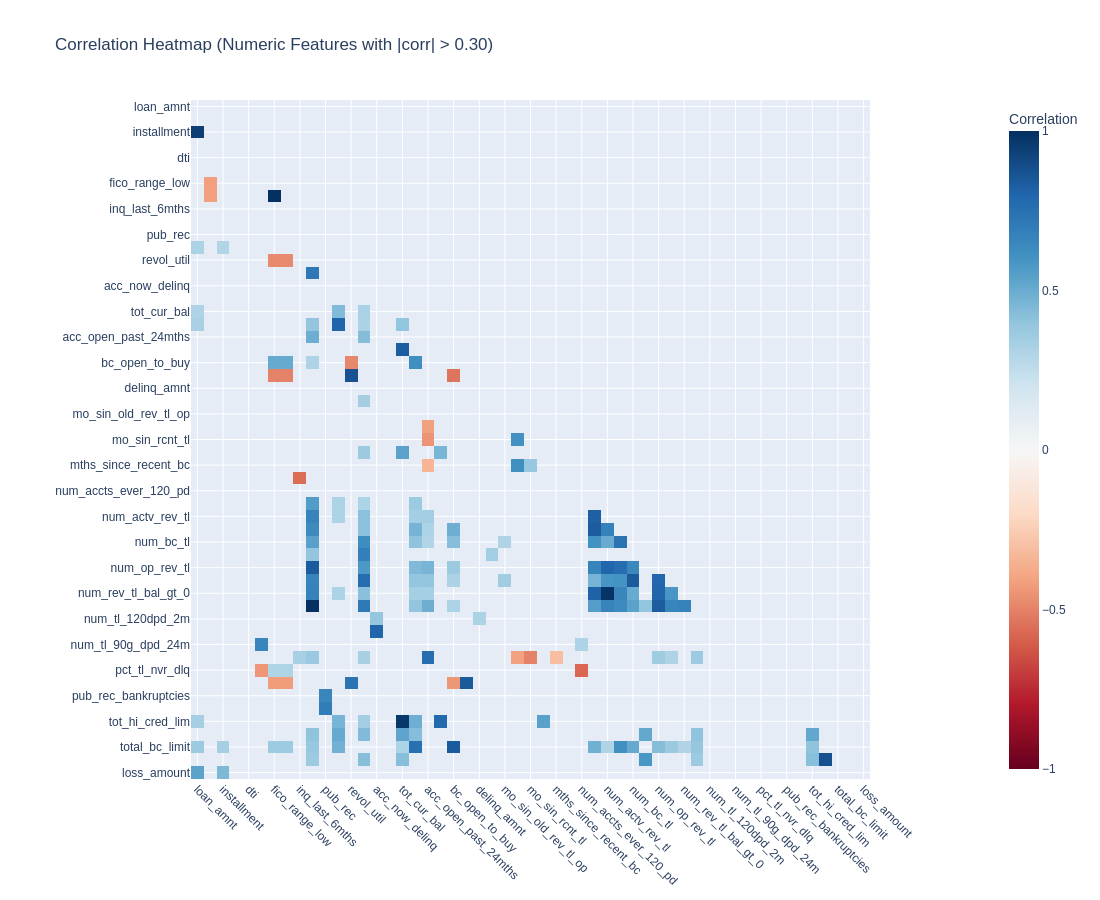

In [14]:
# Select numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr = numeric_df.corr()

# Keep only strong correlations (absolute correlation > 0.30)
corr_filtered = corr.where(corr.abs() > 0.30)

# Drop rows/cols that have no strong correlations
corr_filtered = corr_filtered.dropna(how='all').dropna(axis=1, how='all')

# Convert to long format for Plotly
corr_long = corr_filtered.reset_index().melt(id_vars='index')
corr_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Drop NaN rows (filtered-out correlations)
corr_long = corr_long.dropna(subset=['Correlation'])

# heatmap

# Mask upper triangle to reduce redundancy
mask = np.triu(np.ones_like(corr_filtered, dtype=bool))

fig = px.imshow(
    corr_filtered.mask(mask),
    color_continuous_scale='RdBu',
    zmin=-1,
    zmax=1,
    labels=dict(color='Correlation'),
    title="Correlation Heatmap (Numeric Features with |corr| > 0.30)"
)

fig.update_layout(
    width=1100,
    height=900,
    xaxis={'tickangle': 45},
)

fig.show()


Several numeric features are strongly correlated, particularly those related to loan size, credit limits and revolving balances. Overall, many credit utilisation and account-related variables move together, indicating overlapping information across these features.

In [15]:
# Perform univariate correlation analysis against loss amount

# select only numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = [col for col in num_cols if col != 'loss_amount']

target_corr = df[num_cols].corrwith(df['loss_amount']).dropna().sort_values(key=lambda x: abs(x), ascending=False)
target_corr.head(5)


,0
loan_amnt,0.536035
installment,0.453876
total_bc_limit,0.183729
total_rev_hi_lim,0.154786
int_rate,0.143972


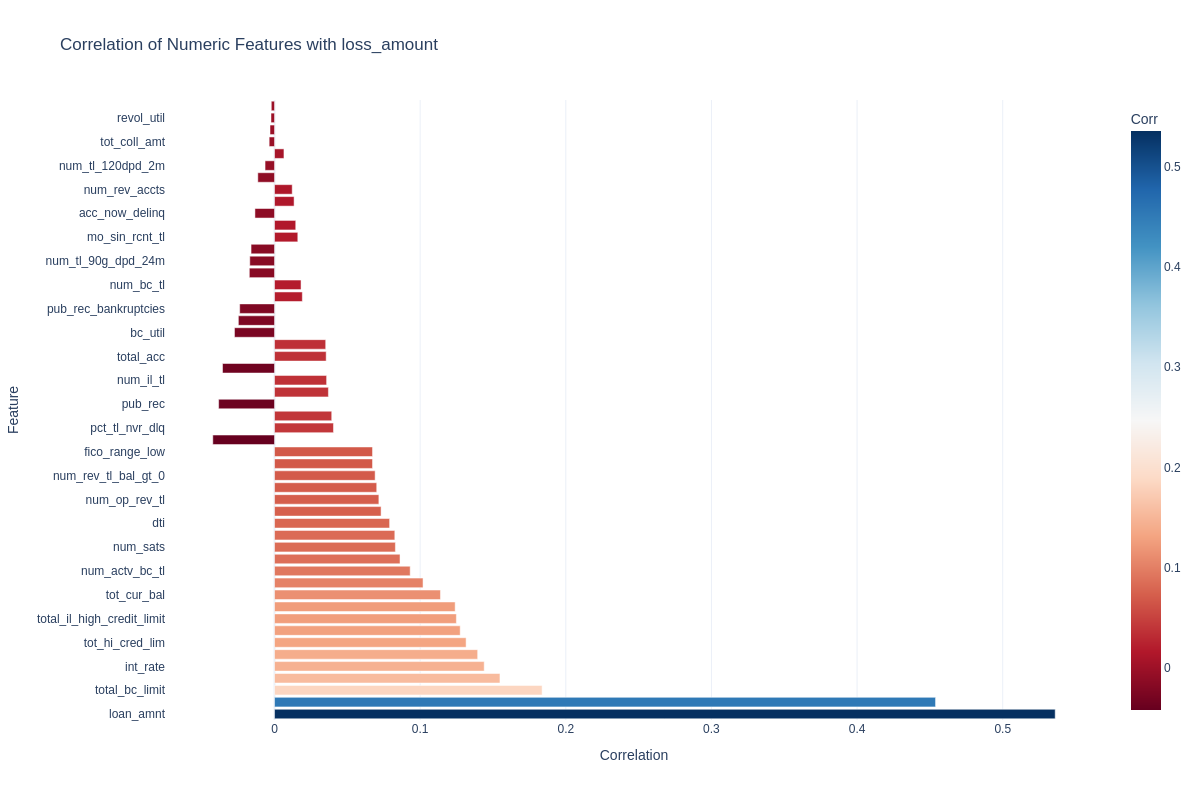

In [16]:
# Convert to DataFrame for Plotly
corr_df = target_corr.reset_index()
corr_df.columns = ['Feature', 'Correlation']

# Plot with Plotly
fig = px.bar(
    corr_df,
    x='Correlation',
    y='Feature',
    orientation='h',
    color='Correlation',
    color_continuous_scale='RdBu',
    title='Correlation of Numeric Features with loss_amount'
)

fig.update_layout(
    width=1200,
    height=800,
    xaxis_title='Correlation',
    yaxis_title='Feature',
    coloraxis_colorbar=dict(title="Corr"),
    template='plotly_white'
)

fig.show()

**Correlation with Target Variable (loss_amount):**
To identify which numeric variables have the strongest linear relationships with the  target loss_amount, a univariate correlation ranking was computed and visualized.

Loan amount and installment size show the strongest correlations with loss, followed by credit limits and balance-related variables.

Most other borrower credit and account-related attributes show weak linear correlations, which is expected in consumer lending datasets. This indicates that linear models may capture only part of the signal, and non-linear models may be better suited for this prediction task.


In [17]:
# FICO range variables were found to be almost perfectly correlated. Consolidating into a single midpoint value to reduce redundancy
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) / 2
df.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace=True)


### Numeric Feature Analysis

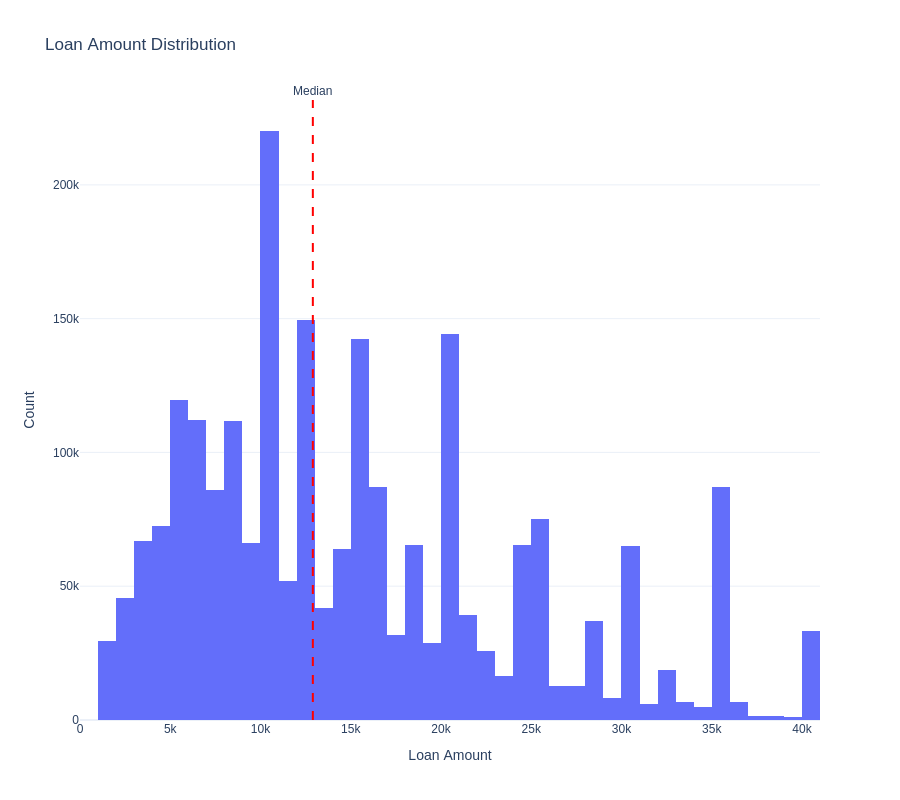

In [18]:
# Review the distribution of loan amounts to identify skew and potential outliers
fig = px.histogram(df, x='loan_amnt', nbins=50, title='Loan Amount Distribution')
fig.update_layout(
    width=900,
    height=800,
    xaxis_title='Loan Amount',
    yaxis_title='Count',
    template='plotly_white'
)

median_loan = df['loan_amnt'].median()
fig.add_vline(x=median_loan, line_dash='dash', line_color='red', annotation_text='Median', annotation_position='top')

fig.show()

Loan amounts cluster in common increments (e.g. 5k, 10k, 15k).
Very large loans (35k–40k) are less common.

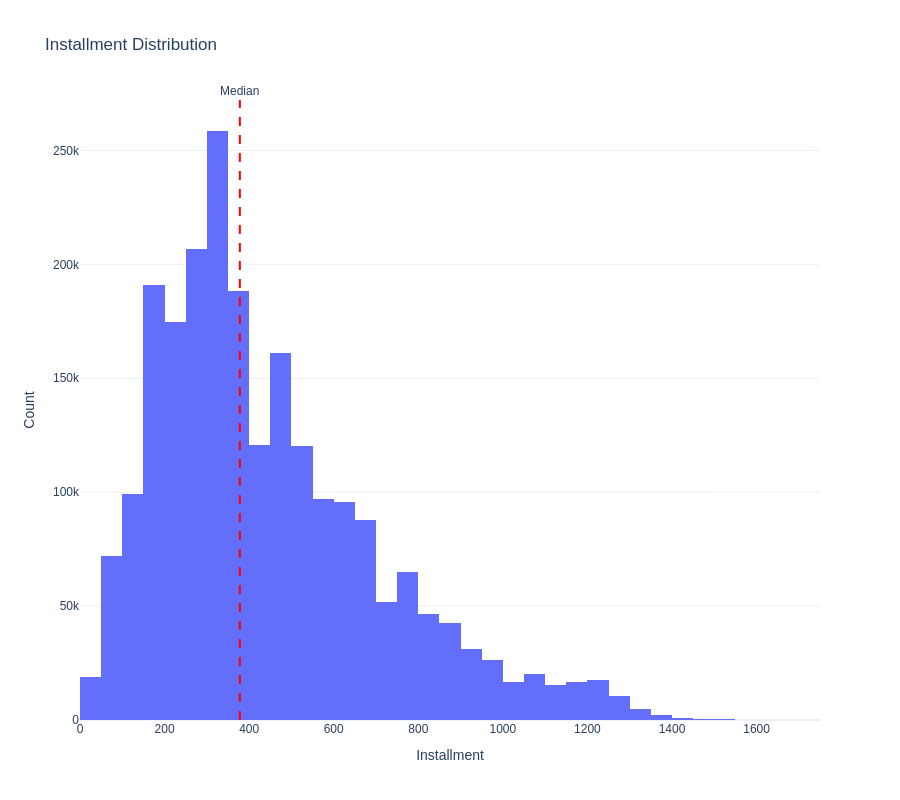

In [19]:
# Review the distribution of Installment (monthly payment) to identify skew and potential outliers
fig = px.histogram(df, x='installment', nbins=50, title='Installment Distribution')
fig.update_layout(width=900, height=800, xaxis_title='Installment', yaxis_title='Count', template='plotly_white')
median_val = df['installment'].median()
fig.add_vline(x=median_val, line_dash='dash', line_color='red', annotation_text='Median', annotation_position='top')
fig.show()

Installments cluster between 150 USD and 600 USD, with a long right tail, mirroring loan amounts

In [20]:
#helper function to plot distribution and outlier
def plot_distribution_with_outliers(
    df,
    column,
    title=None,
    cap_quantile=0.99,
    bins=50,
    width=1200,
    height=600
):
    """
    Plot a side-by-side view of a numeric feature:
    - Left: histogram capped at a given quantile (typical values)
    - Right: box plot with log scale (outliers)
    """

    # Clean data
    series = df[column].dropna()
    series = series[series > 0]

    cap = series.quantile(cap_quantile)
    series_capped = series.clip(upper=cap)
    median_val = series.median()


    if title is None:
        title = f'{column} Distribution and Outlier Analysis'

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
            f'{column} Distribution (Capped at {int(cap_quantile*100)}th Percentile)',
            f'{column} with Outliers (Log Scale)'
        )
    )

    # Histogram
    hist = px.histogram(x=series_capped, nbins=bins )
    for trace in hist.data:
        fig.add_trace(trace, row=1, col=1)

    # Median line
    #fig.add_vline(x=median_val, line_dash='dash', line_color='red', annotation_text='Median', annotation_position='top', row=1, col=1)

    fig.add_vline(x=median_val, line_dash='dash', line_color='red', row=1, col=1)

    # Box plot (log scale)
    box = px.box(y=series, points='outliers')
    for trace in box.data:
        fig.add_trace(trace, row=1, col=2)

    # Layout and axes
    fig.update_layout(title_text=title, width=width, height=height, template='plotly_white', showlegend=False)


    fig.update_xaxes(title_text=column, row=1, col=1)
    fig.update_yaxes(title_text='Count', row=1, col=1)

    fig.update_yaxes( title_text=f'{column} (log scale)', type='log', row=1, col=2)

    fig.show()

    print(f'{column}: median={median_val:,.2f}, '
          f'{int(cap_quantile*100)}th percentile cap={cap:,.2f}, '
          f'max={series.max():,.2f}')


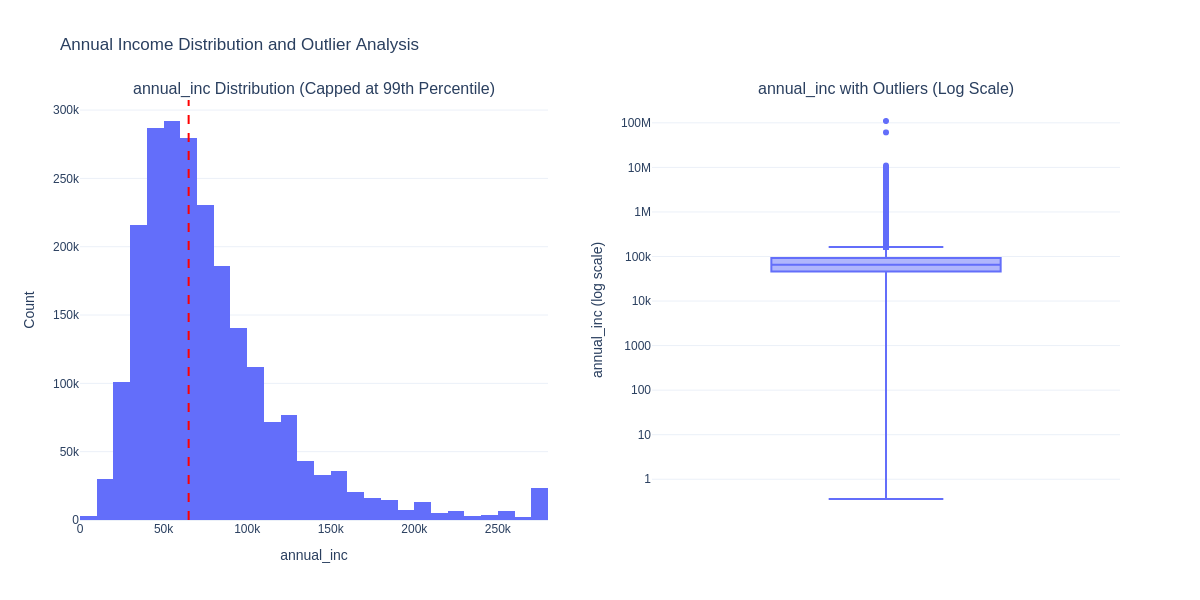

annual_inc: median=65,000.00, 99th percentile cap=270,000.00, max=110,000,000.00


In [21]:
# PLot the distribution of annual income to identify skew and potential outliers
plot_distribution_with_outliers(df, 'annual_inc', title='Annual Income Distribution and Outlier Analysis')

Annual income is highly right-skewed, with most observations concentrated at lower values and a small number of extreme outliers.

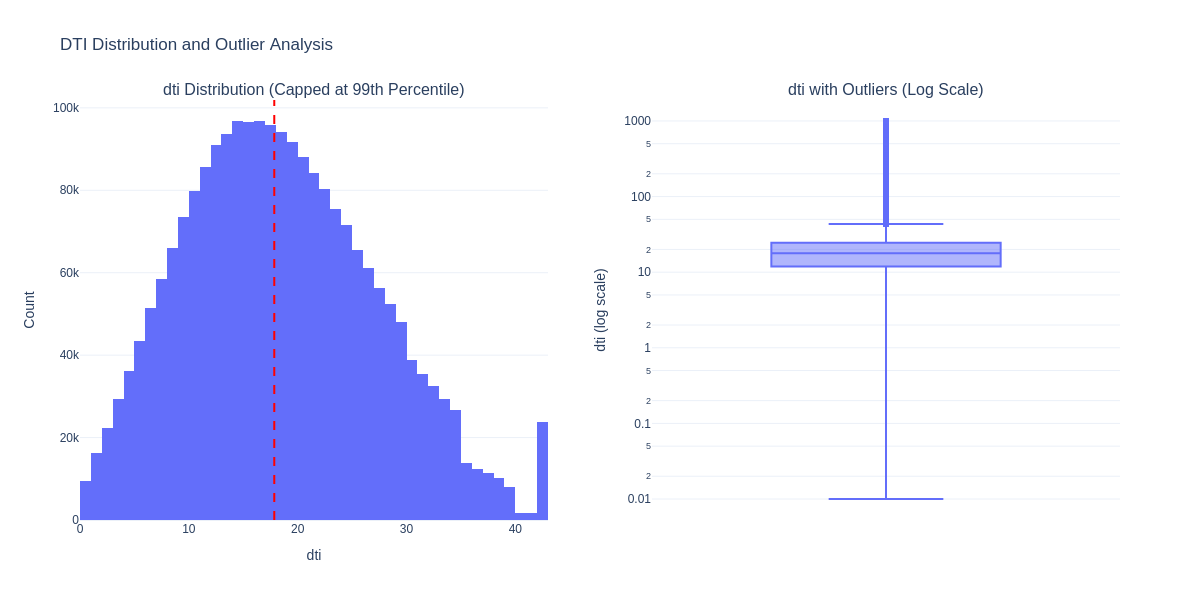

dti: median=17.85, 99th percentile cap=42.72, max=999.00


In [22]:
# Plot the distribution of annual income to identify skew and potential outliers
plot_distribution_with_outliers(df, 'dti', title='DTI Distribution and Outlier Analysis')

Most borrowers have a DTI (Debt-to-Income ratio) between 0% and 40%. Some extreme outliers exists.

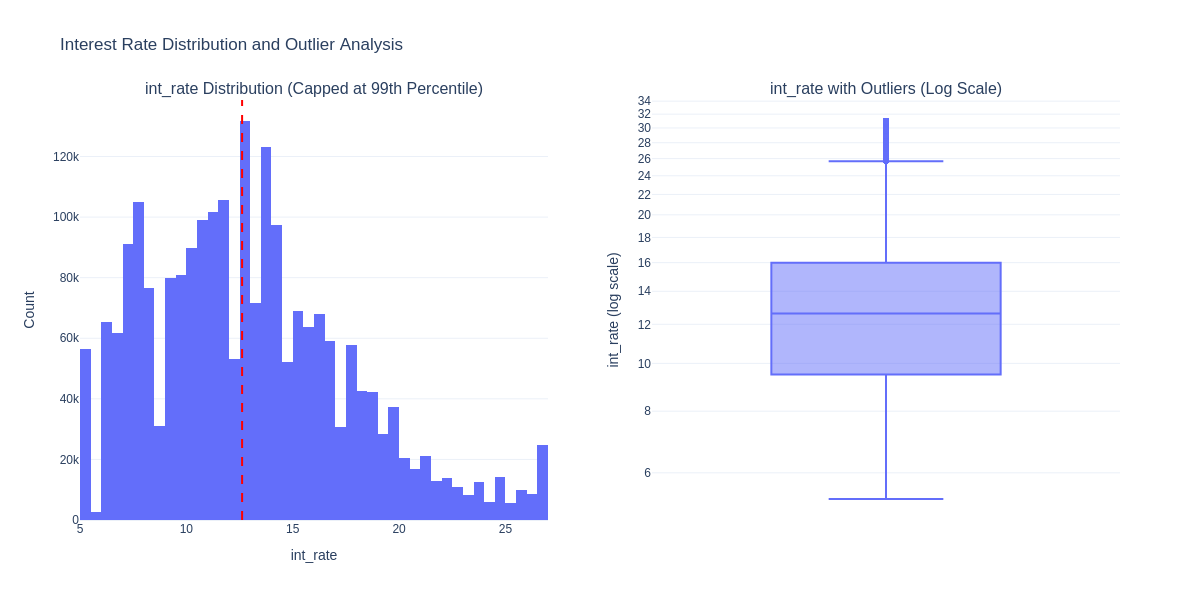

int_rate: median=12.62, 99th percentile cap=26.77, max=30.99


In [23]:
# Plot the distribution of annual income to identify skew and potential outliers
plot_distribution_with_outliers(df, 'int_rate', title='Interest Rate Distribution and Outlier Analysis')

Interest rates cluster between 6% and 18%, with fewer loans above 20%.
with a modest right tail and few extreme outliers.

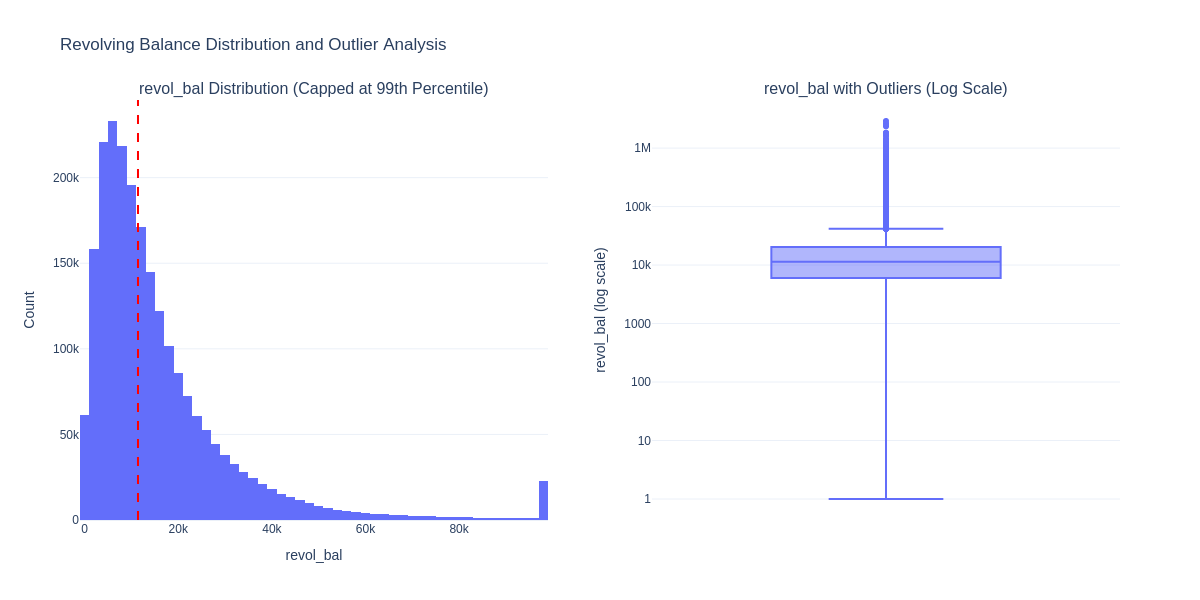

revol_bal: median=11,392.00, 99th percentile cap=98,205.60, max=2,904,836.00


In [24]:
# Plot the distribution of Revolving Balance to identify skew and potential outliers
plot_distribution_with_outliers(df, 'revol_bal', title='Revolving Balance Distribution and Outlier Analysis')

Revolving balances are extremely right-skewed with most values clustered at low levels. Large outliers (1 – 3M) exist but are very few.

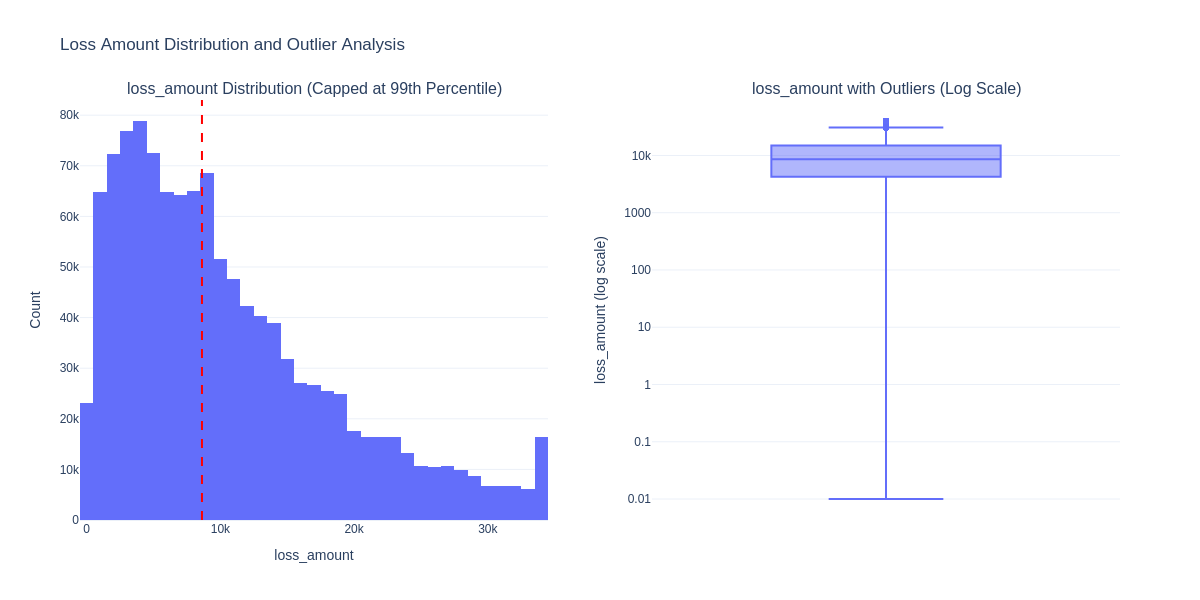

loss_amount: median=8,621.16, 99th percentile cap=34,423.10, max=40,000.00


In [25]:
# Plot the distribution of Losss Amount to identify skew and potential outliers
plot_distribution_with_outliers(df, 'loss_amount', title='Loss Amount Distribution and Outlier Analysis')

Loss amount is highly right-skewed. Most loans show zero loss.
For defaulted loans, loss amounts span from a few hundred up to 40k. The distribution is dominated by the long tail of high-loss loans.

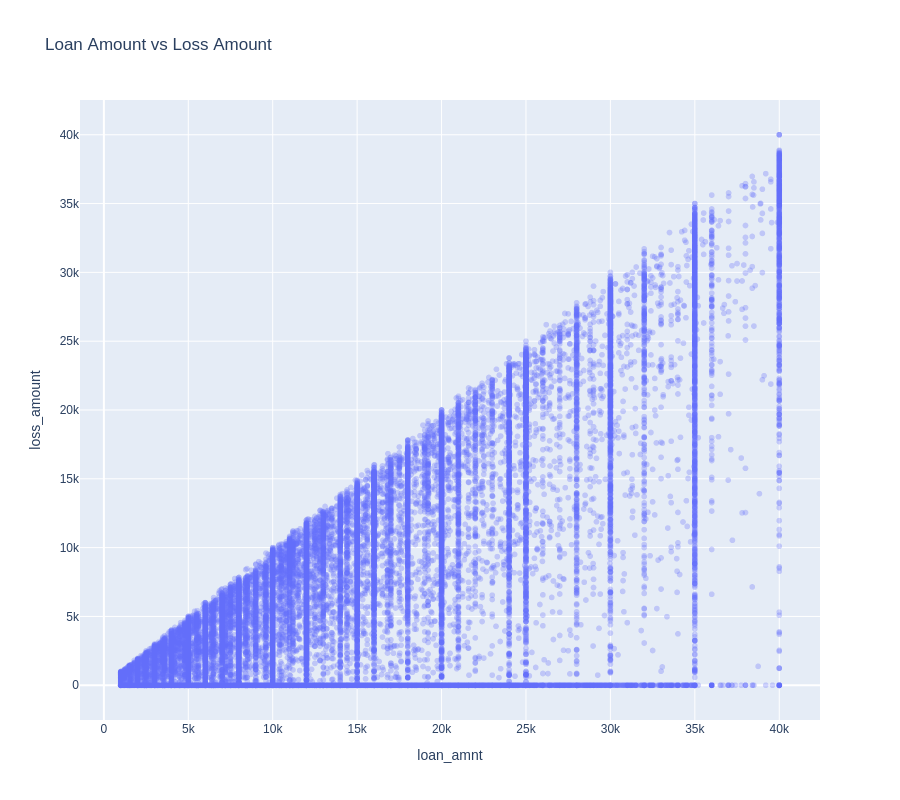

In [26]:
# Sample only for scatterplots, not for correlation
df_sample = df.sample(n=50000, random_state=42)

fig = px.scatter(df_sample, x='loan_amnt', y='loss_amount', opacity=0.3, title='Loan Amount vs Loss Amount')
fig.update_layout(width=900, height=800)
fig.show()


Higher loan amounts lead to higher absolute losses.This is expected, because loss exposure scales directly with the loan amount

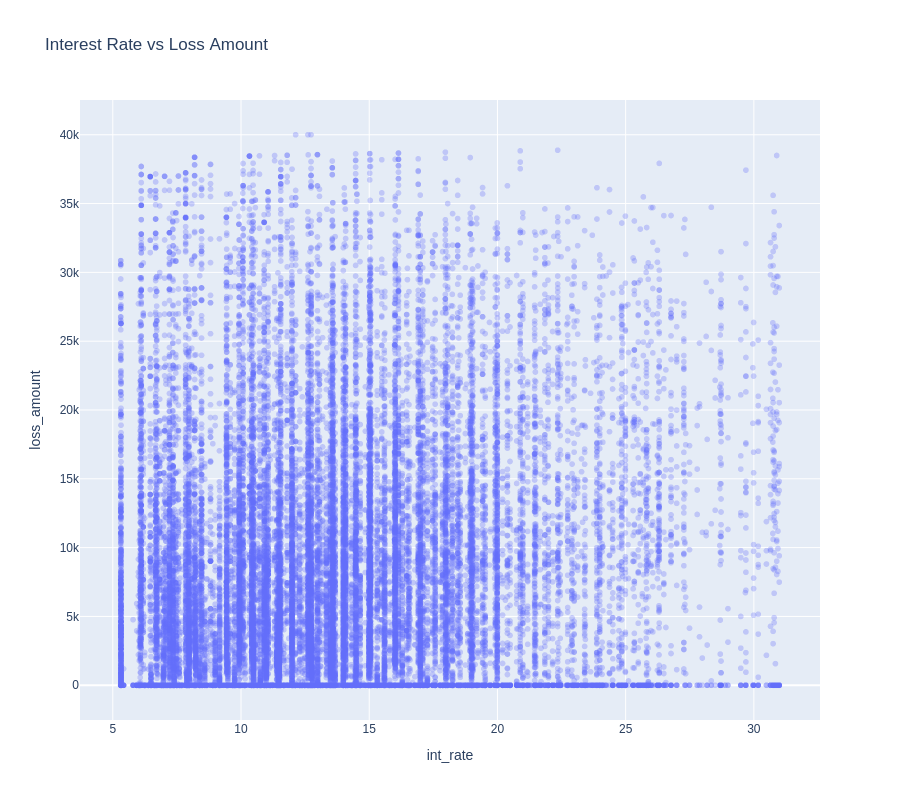

In [27]:

fig = px.scatter(df_sample, x='int_rate', y='loss_amount', opacity=0.3, title='Interest Rate vs Loss Amount')
fig.update_layout(width=900, height=800)
fig.show()

Higher interest rate loans show more high-loss points

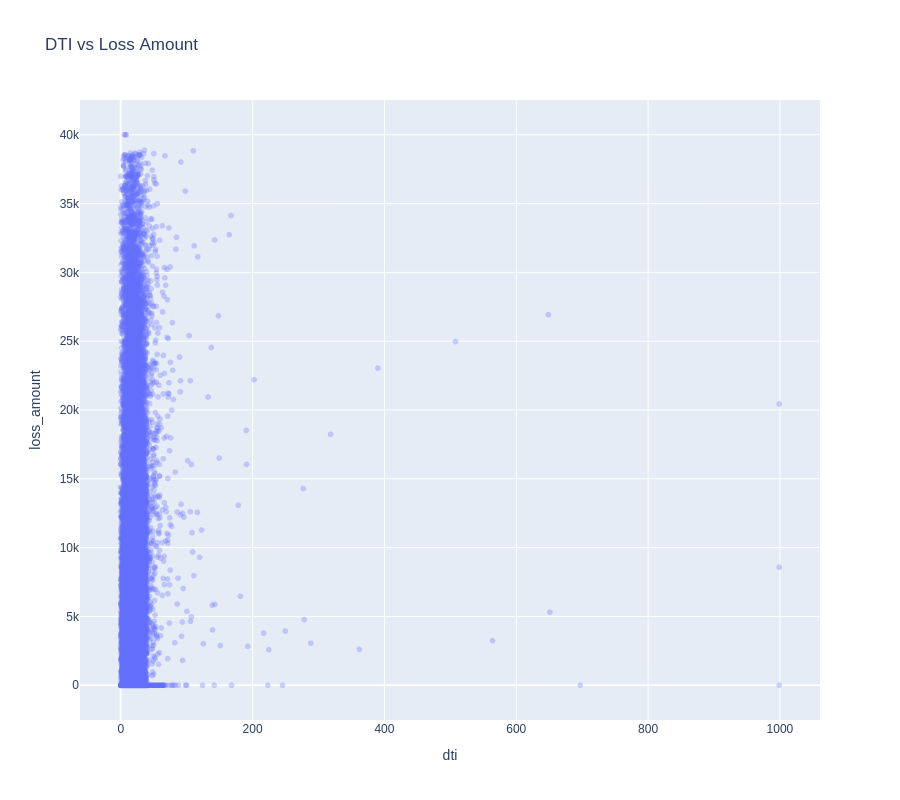

In [28]:

fig = px.scatter(df_sample, x='dti', y='loss_amount', opacity=0.3,
                 title='DTI vs Loss Amount')
fig.update_layout(width=900, height=800)
fig.show()

Most loans cluster in a narrow DTI range,Loss amount does not show a strong linear pattern with DTI. Extreme outliers (DTI above 100, 200, even 600+) are present

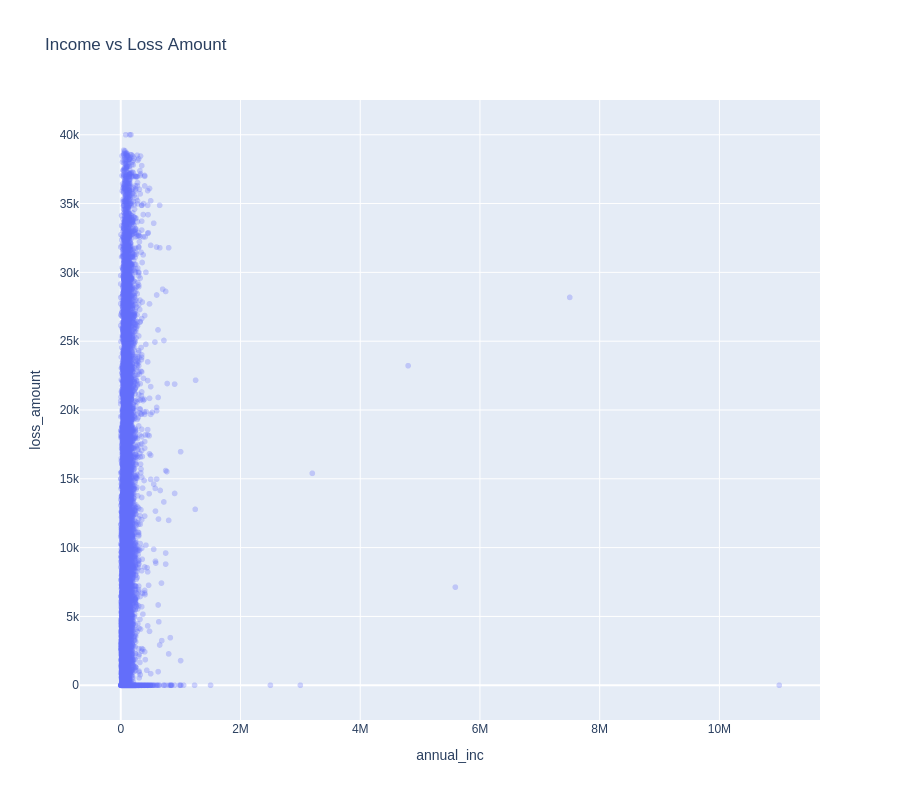

In [29]:
fig = px.scatter(df_sample, x='annual_inc', y='loss_amount', opacity=0.3, title='Income vs Loss Amount')
fig.update_layout(width=900, height=800)
fig.show()


Most borrowers have annual income below ~$150k. Income shows weak correlation with loss amount.Loss severity does not significantly decrease as income increases.

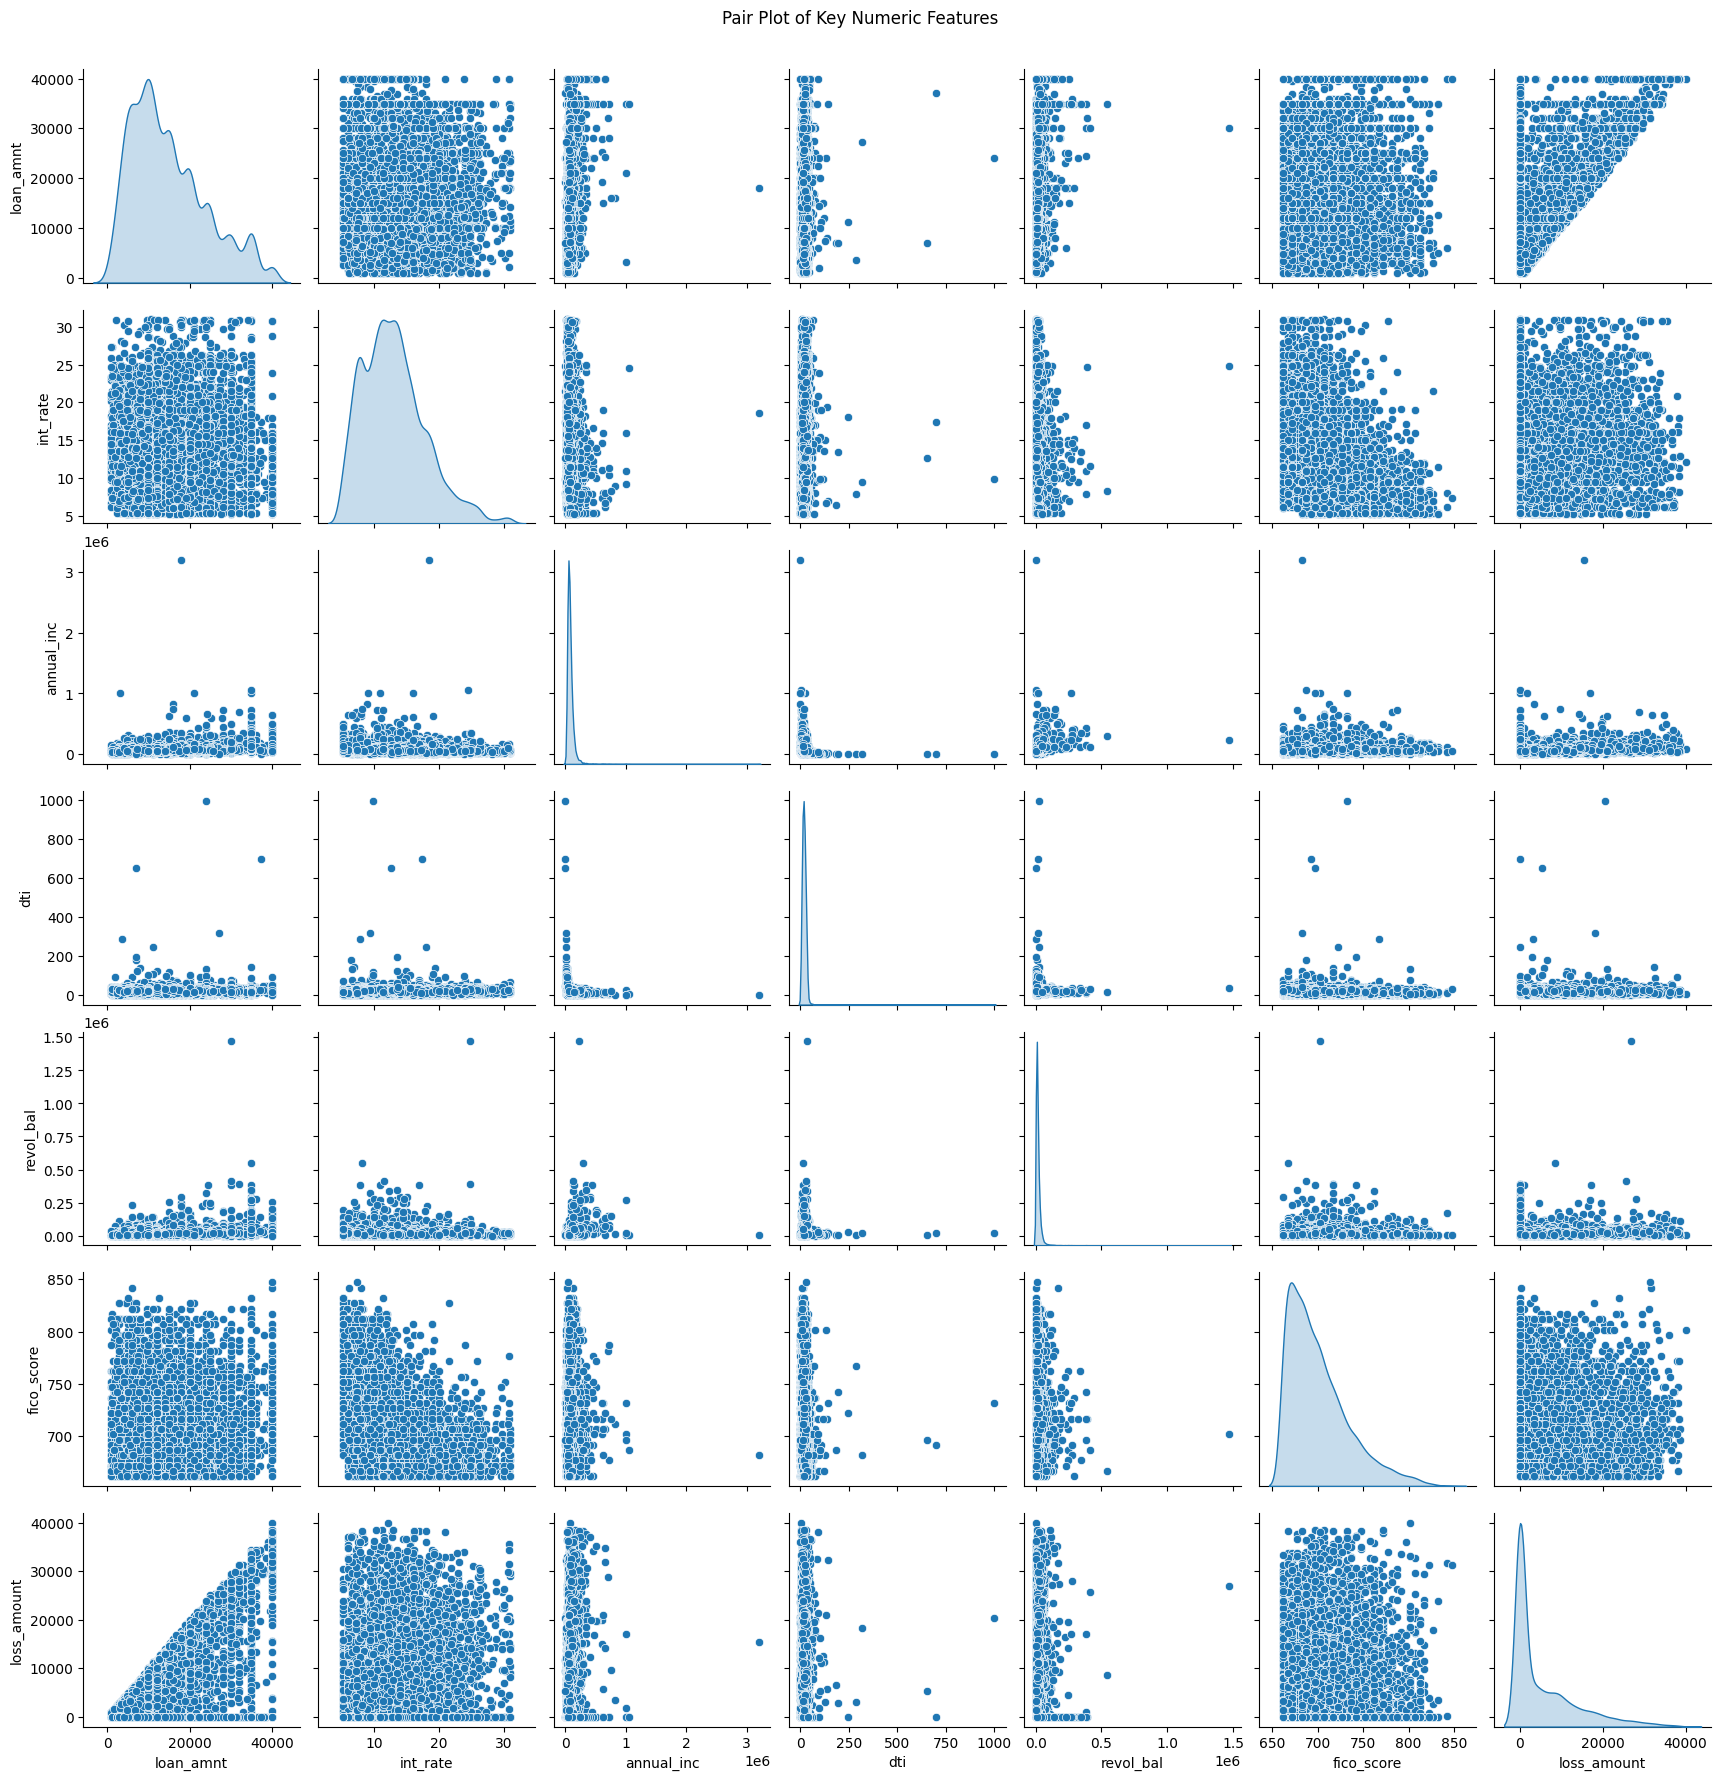

In [30]:

# Select key numeric features (example)
num_features = [
    'loan_amnt',
    'int_rate',
    'annual_inc',
    'dti',
    'revol_bal',
    'fico_score',
    'loss_amount'
]

# Sample to avoid crashing
df_sample = df[num_features].sample(10000, random_state=42)

# Create pairplot
sns.pairplot(df_sample, diag_kind='kde')
plt.suptitle("Pair Plot of Key Numeric Features", y=1.02)
plt.show()


A correlation analysis was performed on all numeric features with less than 30% missing values to understand their relationships with the target variable.

As expected, variables that describe loan performance after issue (such as outstanding principal, total payments received, and last payment amounts)
showed very strong correlations with loss,

* loan_amnt and installment form a nearly linear relationship. Possibly drop
* FICO score displays a clear inverse relationship with loss severity,it a strong risk indicator.
* annual income, DTI, and revolving balance are extremely skewed with heavy outliers, suggesting the need for capping or transformation before modeling.

installment.

These fields represent leakage and will be excluded. Pre-origination features such as loan amount, installment, interest rate, income, DTI, revolving credit utilisation, and credit line counts displayed moderate correlations with loss and were retained as meaningful predictors.

In [31]:
#Identify outliers in numeric columns using IQR
numeric_cols = df.select_dtypes(include=['float64','int64']).columns

outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()
    total = len(df)
    pct = outliers / total * 100

    outlier_summary.append([col, outliers, pct, lower, upper])

outlier_df = pd.DataFrame(outlier_summary,
                          columns=['column', 'outlier_count', 'outlier_pct', 'lower_bound', 'upper_bound'])

In [32]:
#merge dictionary to bring in description and eda_category previously determined
iqr_merged = outlier_df.merge(df_dictionary, on='column', how='left')

#merge dictionary to bring correlatation against loss_amount
corr_df = corr_df.rename(columns={'Feature': 'column','Correlation': 'corr_loss_amount'})


full_analysis = iqr_merged.merge(corr_df[['column', 'corr_loss_amount']],
                                 on='column', how='left')

# Sort by most predictive features (absolute correlation)
full_analysis = full_analysis.sort_values( by='corr_loss_amount', key=lambda x: x.abs(), ascending=False)

# Sort by highest % of outliers
#full_analysis = full_analysis.sort_values('outlier_pct', ascending=False)

full_analysis

,column,outlier_count,outlier_pct,lower_bound,upper_bound,description,eda_category,corr_loss_amount
0,loan_amnt,35215,1.557703,-10000.00000,38000.00000,The listed amount of the loan applied for by t...,Pre-issuance,0.536035
2,installment,66312,2.933249,-260.85500,1105.82500,The monthly payment owed by the borrower if th...,Pre-issuance,0.453876
48,total_bc_limit,129699,5.737114,-24700.00000,63300.00000,Total bankcard high credit/credit limit,Candidate Feature,0.183729
15,total_rev_hi_lim,127152,5.624450,-28050.00000,85950.00000,Total revolving high credit/credit limit,Candidate Feature,0.154786
1,int_rate,41099,1.817976,-0.26000,25.74000,Interest Rate on the loan,Pre-issuance,0.143972
47,total_bal_ex_mort,131127,5.800281,-44295.00000,129537.00000,Total credit balance excluding mortgage,Candidate Feature,0.139476
46,tot_hi_cred_lim,75688,3.347988,-259805.00000,568291.00000,Total high credit/credit limit,Candidate Feature,0.131540
9,revol_bal,137095,6.064269,-15494.00000,41690.00000,Total credit revolving balance,Pre-issuance,0.127480
49,total_il_high_credit_limit,111518,4.932895,-50706.37500,124510.62500,Total installment high credit/credit limit,Candidate Feature,0.124860
18,bc_open_to_buy,180429,7.981109,-16975.50000,32884.50000,Total open to buy on revolving bankcards.,Pre-issuance,0.124025


**Outlier Findings**

Given the presence of extreme values across numeric variables, the Interquartile Range (IQR) method was applied to all numeric fields to identify variables that may contain problematic values.

Many outliers are false positives caused by zero-inflated credit data.

1. Features such as delinq_2yrs, pub_rec, and num_accts_ever_120_pd have zero values for the vast majority of borrowers. So any non-zero value is marked as an outlier, even though these are valid risk indicators

2. Features such as revol_bal, total_bc_limit, and total_rev_hi_lim show heavy skew. These likely reflect borrowers with larger credit exposure. As part of outlier treatment these can be cappeed or transformed.

3. Extremely high values in annual_inc, dti, or revol_bal look unrealistic (e.g. DTI > 300). These will be capped to prevent distortion in model. loss_amount will also be clipped at zero where needed.






### Categorical Exploratory Data Analysis (EDA)


This section examines the key categorical variables in the dataset, including loan grade, loan purpose, home ownership, employment length, verification status, and loan term.

In [33]:
#select categorical columns
cat_cols = [
    "grade",
    "sub_grade",
    "term",
#    'home_ownership', # remove
 #   'verification_status', # remove
    "application_type",
    "initial_list_status",
    "disbursement_method",
    "purpose",
    "emp_length"
]

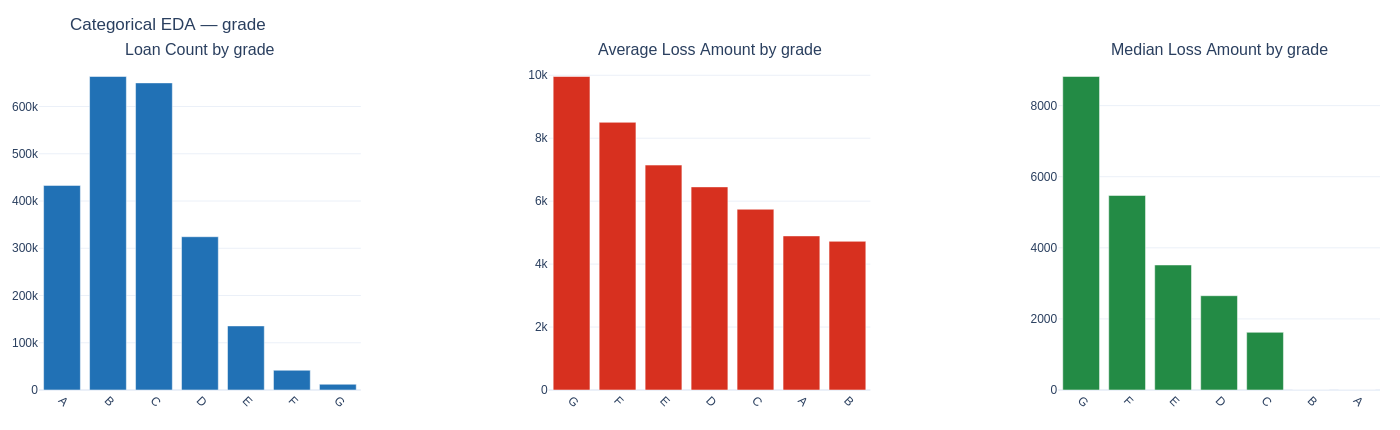

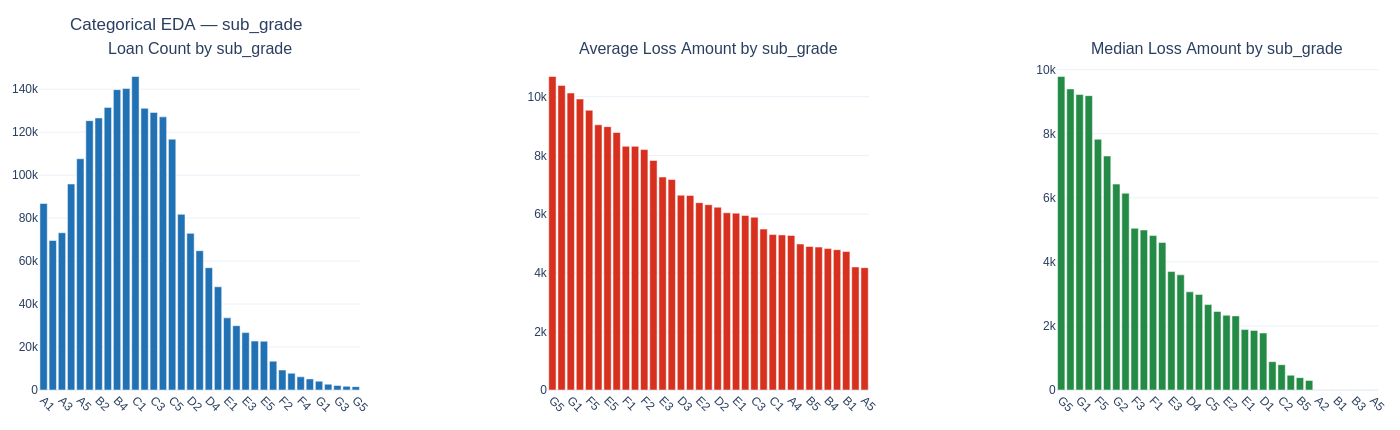

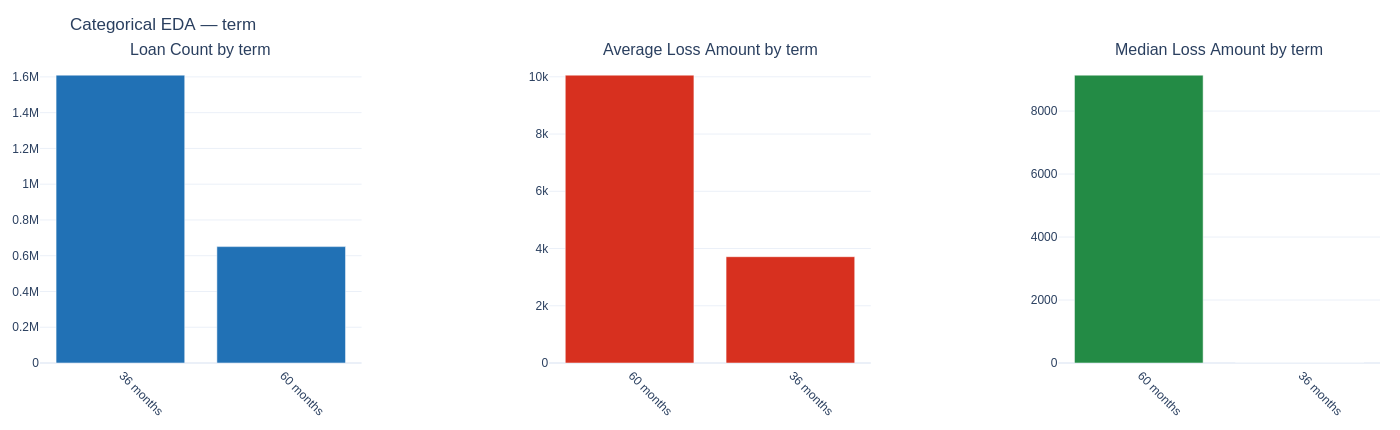

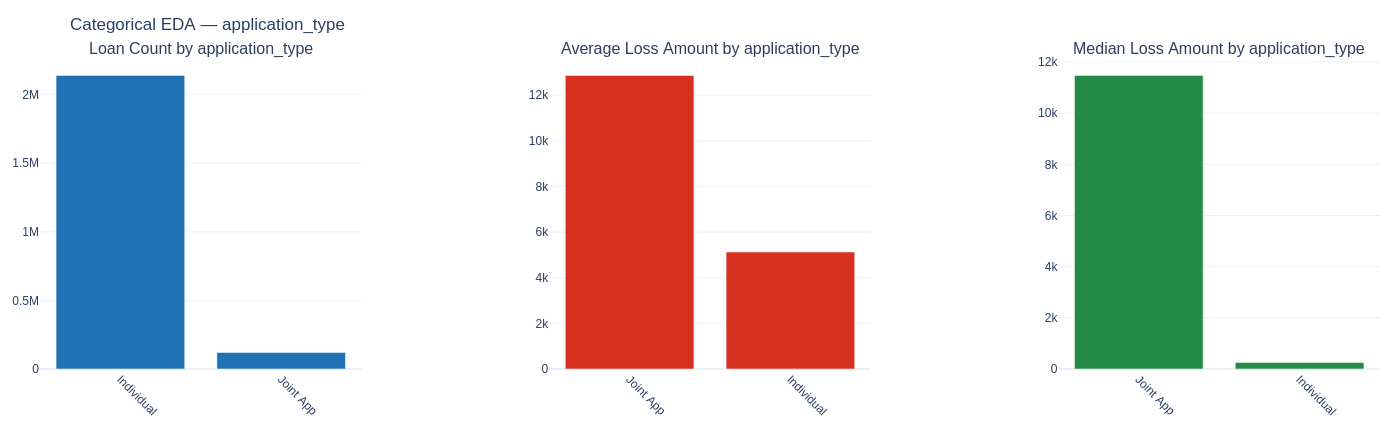

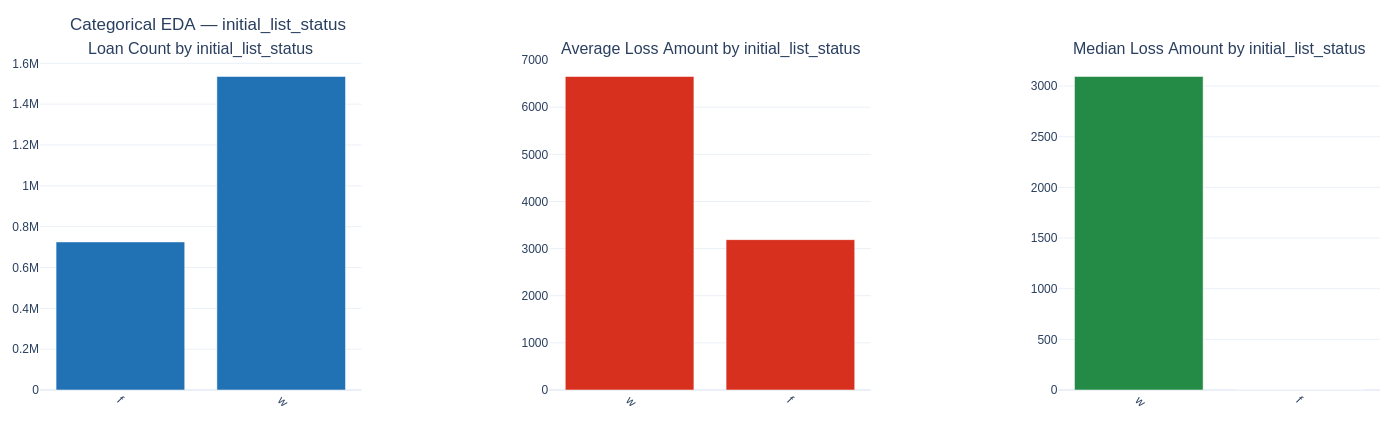

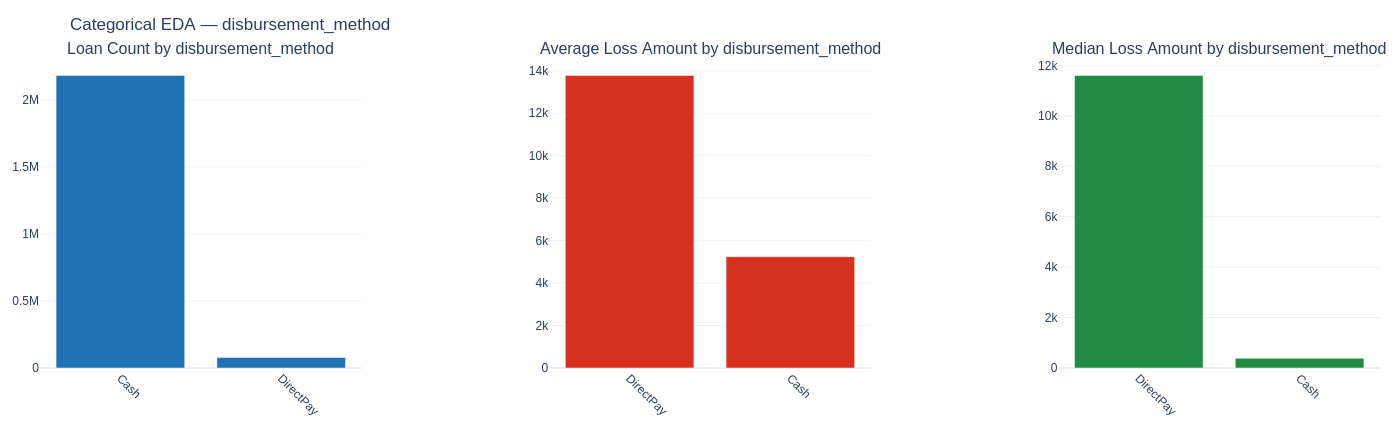

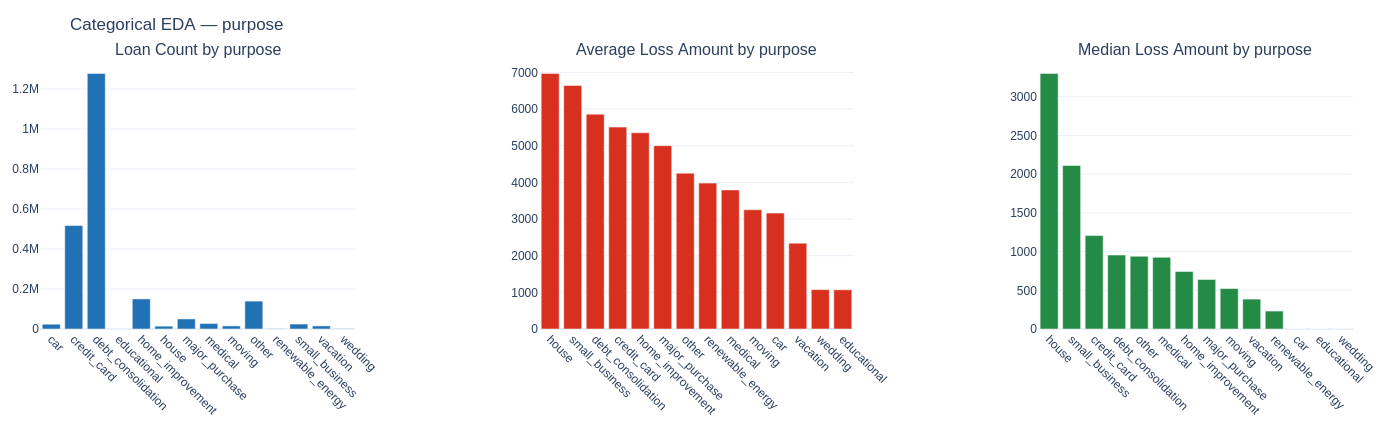

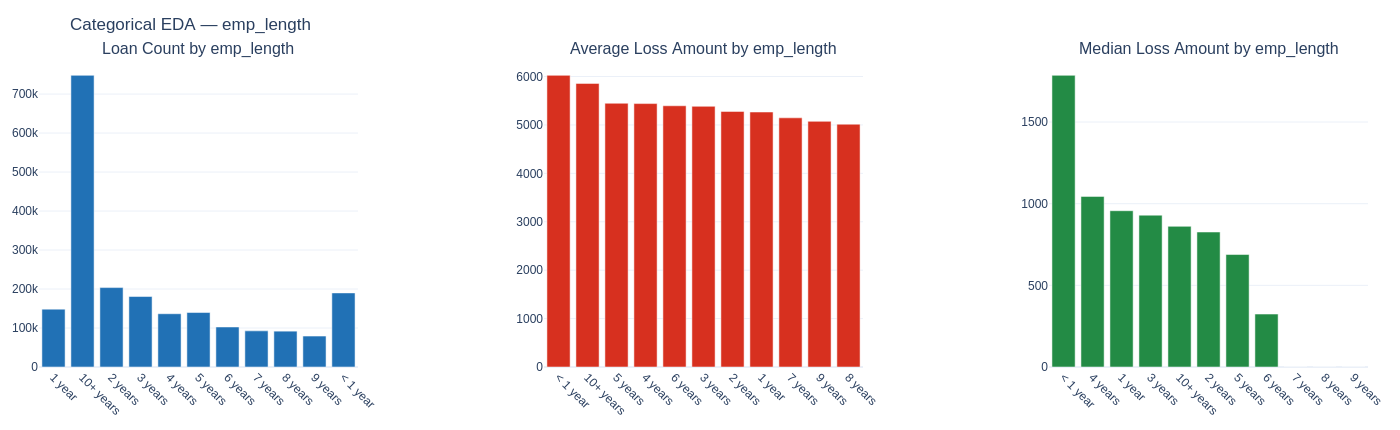

In [34]:
# plot counts, average and median loss amount for each feature
color_count = px.colors.sequential.Blues
color_avg = px.colors.sequential.OrRd
color_med = px.colors.sequential.Greens

for col in cat_cols:

    # Prepare data
    counts = df[col].value_counts().reset_index()
    counts.columns = [col, 'count']
    # sort categories alphabetically for consistency
    counts = counts.sort_values(col)

    avg_loss = df.groupby(col)['loss_amount'].mean().reset_index()
    avg_loss = avg_loss.sort_values('loss_amount', ascending=False)

    med_loss = df.groupby(col)['loss_amount'].median().reset_index()
    med_loss = med_loss.sort_values('loss_amount', ascending=False)


    fig = make_subplots( rows=1, cols=3,subplot_titles=(f"Loan Count by {col}", f"Average Loss Amount by {col}", f"Median Loss Amount by {col}" ), horizontal_spacing=0.14)
    fig.add_trace(go.Bar(x=counts[col], y=counts['count'],marker=dict(color=color_count[-3]), name='Loan Count'), row=1, col=1)

    # Log scale for highly uneven categories
    # fig.update_yaxes(type="log", row=1, col=1)

    fig.add_trace(go.Bar(x=avg_loss[col], y=avg_loss['loss_amount'], marker=dict(color=color_avg[-3]), name='Avg Loss'), row=1, col=2)

    fig.add_trace(go.Bar(x=med_loss[col],y=med_loss['loss_amount'], marker=dict(color=color_med[-3]), name='Median Loss' ), row=1, col=3)

    fig.update_layout(height=430, width=1400, title=dict(text=f"Categorical EDA — {col}"), showlegend=False, template="plotly_white", margin=dict(l=20, r=20, t=60, b=40),  )

    # Rotate x-axis labels
    fig.update_xaxes(tickangle=45)

    fig.show()


**Categorical Feature - EDA**

Key categorical variables were analysed to understand how borrower and loan characteristics relate to loss outcomes. loan count, average loss amount, and median loss amount was calculated for each variable.

* Loan grade is one of the strongest categorical predictors of loss
* Borrowers listed as ANY or MORTGAGE show higher losses than those who OWN or RENT but impact is not clear.
* **Purpose**: Small business, house, and medical loans show the highest losses. Lower-risk categories (e.g., educational, wedding) have the lowest losses but also small volumes.


Grade, sub-grade, loan term, employment length, and purpose show the strongest and most interpretable patterns with loss outcomes.





## Feature preparation and Data Preprocessing

Based on the EDA, a structured preprocessing pipeline is applied to control leakage, handle outliers, encode categorical variables, and prepare a stable feature set for modelling.

In [35]:
#Get all categorical columns
cat_cols_all = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(cat_cols_all)

flat_rows = []

for col in cat_cols_all:
    vc = df[col].value_counts()
    avg = df.groupby(col)['loss_amount'].mean()
    med = df.groupby(col)['loss_amount'].median()

    for cat in vc.index:
        flat_rows.append({
            'feature': col,
            'category': cat,
            'loan_count': vc[cat],
            'avg_loss': avg[cat],
            'median_loss': med[cat]
        })

cat_eda_flat = pd.DataFrame(flat_rows)

cat_eda_flat.sort_values("loan_count", ascending=False).head(10)


['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type', 'disbursement_method']


,feature,category,loan_count,avg_loss,median_loss
1991,disbursement_method,Cash,2182546,5246.147687,390.575
1989,application_type,Individual,2139958,5128.224464,251.975
0,term,36 months,1609754,3714.680734,0.000
1987,initial_list_status,w,1535467,6651.404384,3095.000
212,purpose,debt_consolidation,1277877,5861.473134,955.350
55,home_ownership,MORTGAGE,1111450,5952.830905,203.050
203,loan_status,Fully Paid,1076751,8.520101,0.000
56,home_ownership,RENT,894929,5059.539294,1308.480
61,verification_status,Source Verified,886231,5739.372465,1216.520
204,loan_status,Current,878317,10390.086165,8316.270


In [36]:
cat_eda_flat.shape

(1993, 5)

In [37]:
# apply a quantitative appraoch to check predictive power based on simple count, spread and variance and apply a filter to get potential candidate featuress

# Compute min category size
vol = cat_eda_flat.groupby("feature")["loan_count"].min().rename("min_size")

# Compute predictive spread
spread = (cat_eda_flat.groupby("feature")["avg_loss"].max() -
          cat_eda_flat.groupby("feature")["avg_loss"].min()).rename("spread")

# Compute variance across category losses
var = cat_eda_flat.groupby("feature")["avg_loss"].var().rename("variance")

# Combine metrics
cat_filter = pd.concat([vol, spread, var], axis=1)

# Apply simple rules (volume, spread, variance)
cat_filter["selected"] = (
    (cat_filter["min_size"] >= 1000) &
    (cat_filter["spread"] >= 1500) &
    (cat_filter["variance"] >= 300000)
)

cat_filter

,min_size,spread,variance,selected
feature,,,,
addr_state,14,5941.135822,6.128838e+05,False
application_type,120710,7733.488016,2.990342e+07,True
disbursement_method,78122,8536.956069,3.643981e+07,True
earliest_cr_line,1,34170.890000,4.573722e+06,False
emp_length,79395,1008.819211,9.541504e+04,False
grade,12168,5237.094096,3.697899e+06,True
home_ownership,54,5881.272270,5.634357e+06,False
initial_list_status,725201,3460.964290,5.989137e+06,True
issue_d,24,14286.537419,1.061902e+07,False


In [38]:
# create a copy before outlier treatment & imputing
df_clean = df.copy()

**Outlier treatment**

In [39]:
outlier_cols = ["annual_inc", "dti", "revol_bal", "avg_cur_bal", "tot_cur_bal", "total_bc_limit", "total_rev_hi_lim"]

# Cap outlier to 1st and 99th percentiles to reduce the influence of extreme but rare values
for col in outlier_cols:
    lower = df_clean[col].quantile(0.01)
    upper = df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(lower, upper)

In [40]:
df_clean[outlier_cols].describe(percentiles=[0.01,0.5,0.99])


,annual_inc,dti,revol_bal,avg_cur_bal,tot_cur_bal,total_bc_limit,total_rev_hi_lim
count,2.260664e+06,2.258957e+06,2.260668e+06,2.190322e+06,2.190392e+06,2.210638e+06,2.190392e+06
mean,7.621298e+04,1.848510e+01,1.594565e+04,1.326017e+04,1.401285e+05,2.287885e+04,3.378220e+04
std,4.454018e+04,8.819347e+00,1.592630e+04,1.458605e+04,1.467991e+05,2.119592e+04,2.873270e+04
min,1.680000e+04,1.720000e+00,1.260000e+02,4.260000e+02,2.692000e+03,0.000000e+00,2.600000e+03
1%,1.680000e+04,1.720000e+00,1.260000e+02,4.260000e+02,2.692000e+03,0.000000e+00,2.600000e+03
50%,6.500000e+04,1.784000e+01,1.132400e+04,7.335000e+03,7.924000e+04,1.630000e+04,2.540000e+04
99%,2.700000e+05,4.271000e+01,9.792865e+04,7.447200e+04,6.880450e+05,1.101000e+05,1.635000e+05
max,2.700000e+05,4.271000e+01,9.792998e+04,7.447200e+04,6.880450e+05,1.101000e+05,1.635000e+05


**Feature selection**

In [41]:
# Considering correlation and economic & behavioural factors selecting the following numeric features for modelling

num_keep = [

    # Exposure
    "loan_amnt",
    #"installment",
    "int_rate",

    # Affordability
    "annual_inc",
    "dti",

    # Revolving utilisation / exposure
    "revol_bal",
    "total_bc_limit",
    "total_rev_hi_lim",
    "avg_cur_bal",
    "tot_cur_bal",

    # Credit score
    "fico_score",

    # Account activity (kept minimal)
    "open_acc",
    "num_sats",
    "num_actv_bc_tl",
    "num_rev_tl_bal_gt_0"
]

cat_keep = [
    "grade",
    "sub_grade",
    "term",
    "application_type",
    "initial_list_status",
    "disbursement_method",
    "purpose",
    "emp_length"
]

In [42]:
df_clean['fico_score'] = df_clean['fico_score'].fillna(df_clean['fico_score'].median())

# Median imputation
median_impute = [
    'annual_inc', 'dti', 'avg_cur_bal', 'tot_cur_bal',
    'open_acc', 'num_sats', 'num_actv_bc_tl', 'num_rev_tl_bal_gt_0'
]

for col in median_impute:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Impute with 0 when no revolving activity
df_clean['revol_bal'] = df_clean['revol_bal'].fillna(0)
df_clean['total_bc_limit'] = df_clean['total_bc_limit'].fillna(0)
df_clean['total_rev_hi_lim'] = df_clean['total_rev_hi_lim'].fillna(0)


# Convert issue date to year
df_clean['issue_d'] = pd.to_datetime(df_clean['issue_d'], format='%b-%Y', errors='coerce')
df_clean['issue_year'] = df_clean['issue_d'].dt.year
df_clean['issue_year'] = df_clean['issue_year'].fillna(df_clean['issue_year'].median())

#drop issue date
df_clean.drop(columns=['issue_d'], inplace=True)

In [43]:
# Convert employment length to number
df_clean['emp_length'] = df_clean['emp_length'].astype(str).str.strip()

emp_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    'nan': None
}

df_clean['emp_length'] = df_clean['emp_length'].replace(emp_map)
df_clean['emp_length'] = pd.to_numeric(df_clean['emp_length'], errors='coerce')
df_clean['emp_length'] = df_clean['emp_length'].fillna(df_clean['emp_length'].median()).astype('Int64')


# encode loan term
df_clean['term'] = (df_clean['term'].astype(str).str.extract(r'(\d+)').astype(float))
# fill missing with most common
df_clean['term'] = df_clean['term'].fillna(df_clean['term'].mode()[0]).astype(int)


# encode grade
grade_map = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
df_clean['grade'] = df_clean['grade'].astype(str).str.strip().map(grade_map)
# Fill missing with median
df_clean['grade'] = df_clean['grade'].fillna(df_clean['grade'].median()).astype('Int64')

# Sub-grade ordinal encoding
# list of all sub-grades
subgrades = [
    "A1","A2","A3","A4","A5",
    "B1","B2","B3","B4","B5",
    "C1","C2","C3","C4","C5",
    "D1","D2","D3","D4","D5",
    "E1","E2","E3","E4","E5",
    "F1","F2","F3","F4","F5",
    "G1","G2","G3","G4","G5"
]

# Create mapping: A1 → 1, A2 → 2, ..., G5 → 35
subgrade_map = {sg: i+1 for i, sg in enumerate(subgrades)}

df_clean['sub_grade'] = df_clean['sub_grade'].astype(str).str.strip().map(subgrade_map)
# Handle missing or unexpected values
median_grade = df_clean['sub_grade'].median()
df_clean['sub_grade'] = df_clean['sub_grade'].fillna(median_grade).astype('Int64')

In [44]:
# Impute categorical strings
cat_string_cols = [
    "grade",
    "sub_grade",
    "term",
    "application_type",
    "initial_list_status",
    "disbursement_method",
    "purpose"
]

for col in cat_string_cols:
    df[col] = df[col].fillna("Unknown")

In [45]:
keep_list = num_keep + cat_keep + ["loss_amount"] + ["issue_year"]
#create clean dataset for modelliing.
df_model = df_clean[keep_list].copy()
df_model.sample(5)

,loan_amnt,int_rate,annual_inc,dti,revol_bal,total_bc_limit,total_rev_hi_lim,avg_cur_bal,tot_cur_bal,fico_score,...,grade,sub_grade,term,application_type,initial_list_status,disbursement_method,purpose,emp_length,loss_amount,issue_year
103316,3925.0,13.33,25000.0,31.49,6775.0,9400.0,9400.0,8774.0,52646.0,682.0,...,3,13,36,Individual,f,Cash,debt_consolidation,8,0.00,2015.0
1377970,11000.0,11.31,75000.0,24.83,10106.0,8200.0,18200.0,4698.0,42286.0,697.0,...,2,8,36,Individual,w,Cash,debt_consolidation,2,10218.46,2018.0
1333496,5000.0,7.62,30000.0,18.52,4820.0,4700.0,8600.0,2547.0,30563.0,732.0,...,1,3,36,Individual,w,Cash,credit_card,0,0.00,2014.0
1426558,20000.0,7.21,75000.0,16.06,35114.0,23000.0,53600.0,15508.0,139572.0,777.0,...,1,3,60,Individual,w,DirectPay,credit_card,8,18878.57,2018.0
322244,35000.0,13.33,103000.0,12.86,58352.0,90000.0,97600.0,12870.0,128702.0,672.0,...,3,13,36,Individual,f,Cash,debt_consolidation,9,0.00,2015.0


In [46]:
df_model = df_model.dropna().reset_index(drop=True)
#df_model.isna().sum().sort_values(ascending=False).head(100)

In [47]:
cols = ["application_type", "initial_list_status", "disbursement_method", "purpose"]
for c in cols:
    df_model[c] = df_model[c].astype("category")

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 24 columns):
 #   Column               Dtype   
---  ------               -----   
 0   loan_amnt            float64 
 1   int_rate             float64 
 2   annual_inc           float64 
 3   dti                  float64 
 4   revol_bal            float64 
 5   total_bc_limit       float64 
 6   total_rev_hi_lim     float64 
 7   avg_cur_bal          float64 
 8   tot_cur_bal          float64 
 9   fico_score           float64 
 10  open_acc             float64 
 11  num_sats             float64 
 12  num_actv_bc_tl       float64 
 13  num_rev_tl_bal_gt_0  float64 
 14  grade                Int64   
 15  sub_grade            Int64   
 16  term                 int64   
 17  application_type     category
 18  initial_list_status  category
 19  disbursement_method  category
 20  purpose              category
 21  emp_length           Int64   
 22  loss_amount          float64 
 23  issue_y

## Modelling

### Baseline Models


Baseline linear models are used to establish a performance benchmark and assess whether relationships are predominantly linear.

In [48]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso


# Use sample for baseline speed
df_small = df_model.sample(120_000, random_state=42).copy()
y = df_small["loss_amount"]
X = df_small.drop(columns=["loss_amount"])

num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



Numeric columns: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'total_bc_limit', 'total_rev_hi_lim', 'avg_cur_bal', 'tot_cur_bal', 'fico_score', 'open_acc', 'num_sats', 'num_actv_bc_tl', 'num_rev_tl_bal_gt_0', 'grade', 'sub_grade', 'term', 'emp_length', 'issue_year']
Categorical columns: ['application_type', 'initial_list_status', 'disbursement_method', 'purpose']


In [49]:
# model evaluation helper function
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2  = r2_score(y_test, preds)

    print(f"\n------- {name} -------")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE : {mae:,.2f}")
    print(f"R²  : {r2:.4f}")

    return {"model": name, "rmse": rmse, "mae": mae, "r2": r2}


In [50]:
#Linear Regression
linreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
metrics_lr = evaluate_model("Linear Regression", linreg, X_test, y_test)



------- Linear Regression -------
RMSE: 5,586.21
MAE : 4,053.18
R²  : 0.5046


In [51]:
# Ridge Regression
ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
metrics_ridge = evaluate_model("Ridge Regression", ridge, X_test, y_test)



------- Ridge Regression -------
RMSE: 5,586.14
MAE : 4,053.14
R²  : 0.5046


In [52]:
# Lasso Regression

lasso = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.001))
])

lasso.fit(X_train, y_train)
metrics_lasso = evaluate_model("Lasso Regression", lasso, X_test, y_test)



------- Lasso Regression -------
RMSE: 5,586.21
MAE : 4,053.18
R²  : 0.5046


In [53]:
# Linear Model Results
results = pd.DataFrame([metrics_lr, metrics_ridge, metrics_lasso])
results


,model,rmse,mae,r2
0,Linear Regression,5586.209336,4053.177790,0.504557
1,Ridge Regression,5586.140064,4053.136239,0.504569
2,Lasso Regression,5586.208712,4053.176870,0.504557


All three linear models, Linear Regression, Ridge, and Lasso—show almost identical performance, with RMSE ~5,585, MAE ~4,054, and R² ~0.50.

* The similar performance across linear and regularized models indicates that regularization provides limited additional benefit for this feature set.

* The models explain roughly half of the variance in loan losses, suggesting that a substantial portion of loss behaviour is driven by non-linear effects and interactions between borrower attributes.

* Ridge Regression achieves marginally better performance but does not materially improve predictive accuracy.

* Ridge Regression achieves a marginally better performance



### LightGBM Model

Given the performance ceiling of linear models, it is clear that a gradient boosting approach is needed to better capture non-linear credit risk patterns.

Several modeling approaches were considered, including Random Forests, Gradient Boosting, and XGBoost. LightGBM was selected as the final model due to superior performance on large tabular datasets, ability to capture non-linear credit risk relationships, and strong interpretability when combined with SHAP analysis.

In [57]:
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [58]:
y = df_model["loss_amount"]
X = df_model.drop(columns=["loss_amount"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [59]:
# Using objective='regression' with rmse as it minimizes large errors which is important for loans
lgb_model = lgb.LGBMRegressor(
    device="gpu",
    gpu_device_id=0,
    n_jobs=1,
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=63,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=10,
    objective="regression",
    random_state=42
)

# While R² reflects the inherent volatility of recovery rates in credit risk, RMSE was prioritized as the primary performance metric
# to ensure the model effectively penalises and minimises large-scale prediction errors on high-exposure loans.
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    categorical_feature=cat_cols,
    callbacks=[log_evaluation(period=100)]
)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 1808534, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-80GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (34.50 MB) transferred to GPU in 0.051242 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 5540.191304
[100]	valid_0's rmse: 4741.02	valid_0's l2: 2.24773e+07
[200]	valid_0's rmse: 4663.91	valid_0's l2: 2.1752e+07
[300]	valid_0's rmse: 4647.59	valid_0's l2: 2.16001e+07
[400]	valid_0's rmse: 4639.52	valid_0's l2: 2.15251e+07
[500]	valid_0's rmse: 4634.44	valid_0's l2: 2.14781e+07
[600]	valid_0's rmse: 4631.36	valid_0's l2: 2.14495e+07
[700]	valid_0's rmse: 4628.5	valid_0's l2: 2.1423e+07
[800]	valid_0's rmse: 4626.

LGBMRegressor(colsample_bytree=0.8, device='gpu', gpu_device_id=0,
              learning_rate=0.03, n_estimators=800, n_jobs=1, num_leaves=63,
              objective='regression', random_state=42, reg_alpha=0.1,
              reg_lambda=10, subsample=0.8)

In [60]:
preds = lgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)

print("LightGBM RMSE:", rmse)
print("LightGBM MAE :", mae)
print("LightGBM R²  :", r2)


LightGBM RMSE: 4626.340683276258
LightGBM MAE : 2808.787451335105
LightGBM R²  : 0.6603021714047904


RMSE: 4626  
MAE:  2809  
R² :  0.660

The LightGBM model significantly outperformed all baseline linear models. While Linear, Ridge, and Lasso regressions explained roughly 50 percent of the variance in loan losses (R² ≈ 0.50), LightGBM increased explanatory power to 66 percent (R² ≈ 0.66), reducing RMSE from 5585 to 4642. This improvement reflects LightGBM’s ability to capture non-linear relationships, feature interactions, and complex credit risk patterns that linear models cannot represent. These results demonstrate that tree-based gradient boosting models are substantially more effective for loan loss prediction and offer more reliable decision-support value for a credit risk setting.

## Validation and tuning

Cross validation and Hyperparameter tuning

### Cross Validation

In [61]:
#Cross validation of LightGBM

from sklearn.model_selection import KFold
# Use full df_model or df_small, but be consistent
#y = df_model["loss_amount"]
#X = df_model.drop(columns=["loss_amount"])

# Ensure categorical cols are dtype 'category'
#X[c] = X[c].astype("category")

cv = KFold(n_splits=3, shuffle=True, random_state=42)

def lgb_cv(model, X, y, cv, cat_cols):
    rows = []
    for fold, (tr, te) in enumerate(cv.split(X), 1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        model.fit(
            X_tr, y_tr,
            categorical_feature=cat_cols
        )

        preds = model.predict(X_te)
        rmse = np.sqrt(mean_squared_error(y_te, preds))
        mae = mean_absolute_error(y_te, preds)
        r2 = r2_score(y_te, preds)

        rows.append({"fold": fold, "rmse": rmse, "mae": mae, "r2": r2})

    out = pd.DataFrame(rows)
    summary = out[["rmse", "mae", "r2"]].agg(["mean", "std"])
    return out, summary



lgb_folds, lgb_summary = lgb_cv(lgb_model, X, y, cv=cv, cat_cols=cat_cols)

lgb_folds, lgb_summary

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2611
[LightGBM] [Info] Number of data points in the train set: 1507112, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-80GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (28.75 MB) transferred to GPU in 0.046218 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 5547.173422
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 1507112, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-80GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[L

(   fold         rmse          mae        r2
 0     1  4621.696832  2808.548266  0.659454
 1     2  4624.558790  2818.255178  0.661455
 2     3  4632.481794  2812.840047  0.659721,
              rmse          mae        r2
 mean  4626.245805  2813.214497  0.660210
 std      5.586892     4.864277  0.001087)

Cross-validation results show low variance across folds, indicating that model performance is stable and not dependent on a specific train-test split.


### Hyperparameter tuning

In [62]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Use a smaller sample for grid search speed
df_gs = df_model.sample(200_000, random_state=42).copy()
y_gs = df_gs["loss_amount"]
X_gs = df_gs.drop(columns=["loss_amount"])

for c in cat_cols:
    X_gs[c] = X_gs[c].astype("category")

# 2. Use the same parameter grid
param_grid = {
    "n_estimators": [500, 900],
    "learning_rate": [0.03, 0.05],
    "num_leaves": [25, 63],
    "min_child_samples": [3, 20],
    "colsample_bytree": [0.8, 0.9],
}

# Use Halving Search
gs = HalvingGridSearchCV(
    lgb_model,
    param_grid,
    factor=3,
    resource='n_samples',
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    random_state=42
)

# 4. Fit
gs.fit(X_gs, y_gs, categorical_feature=cat_cols)

# 5. Output (Matches your original format)
print("Best params:", gs.best_params_)
print("Best CV RMSE:", -gs.best_score_)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2603
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-80GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (3.81 MB) transferred to GPU in 0.006225 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 5542.033409
Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'min_child_samples': 3, 'n_estimators': 500, 'num_leaves': 25}
Best CV RMSE: 4695.496603747783


The model was tuned using HalvingGridSearchCV on the A100 GPU.

The search identified a conservative configuration (num_leaves: 25, n_estimators: 500) as optimal for the 200k sample.

While these "best" parameters provide a robust baseline, the higher-capacity Initial Model (800 trees, 63 leaves) was retained. Testing on the full 2-million-row dataset confirmed that the larger data volume effectively supports a more complex model without overfitting, yielding a superior final RMSE.

In [65]:
# Hyperparameter Tuning Evaluation

# Best params from HalvingGridSearchCV output
best_params = {
    "colsample_bytree": 0.9,
    "learning_rate": 0.03,
    "min_child_samples": 3,
    "n_estimators": 500,
    "num_leaves": 25
}

# Refit model on full training set
tuned_lgb_model = lgb.LGBMRegressor(
    **best_params,
    objective="regression",
    random_state=42,
    verbose=-1
)

tuned_lgb_model.fit(X_train, y_train,categorical_feature=cat_cols)

# Evaluate
preds = tuned_lgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)

print("Tuned LightGBM")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")

Tuned LightGBM
RMSE: 4,664.59
MAE : 2,845.08
R²  : 0.6547


The tuned model achieved an $R^2$ of 0.6547, explaining ~65% of loss variance.The MAE (2,845) and RMSE (4,664) represent a marginal performance decrease compared to the initial model.Since the initial model (800 trees, 63 leaves) better utilized the full 2M-row dataset to achieve superior accuracy, it is selected for the final business recommendations and SHAP analysis.

## Model Explainability and Feature Importance


To interpret the LightGBM model and understand which features drive predicted loan losses, SHAP (SHapley Additive exPlanations) is used. SHAP values quantify the contribution of each feature to an individual prediction.

The following SHAP summary plot shows the most influential features and the direction of their impact on predicted loss amounts.

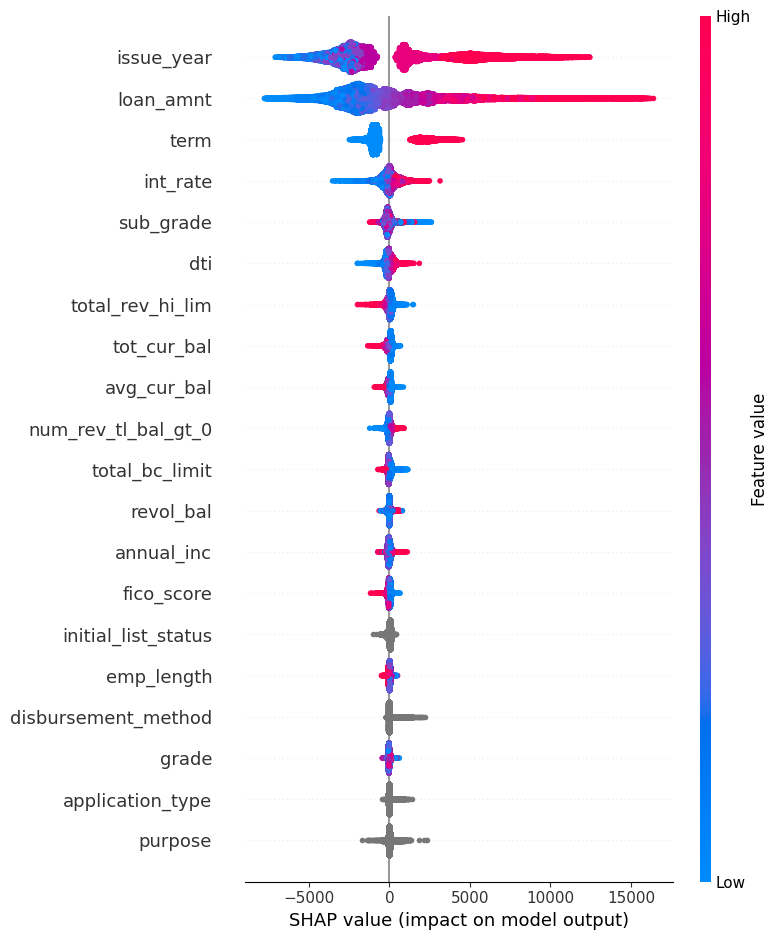

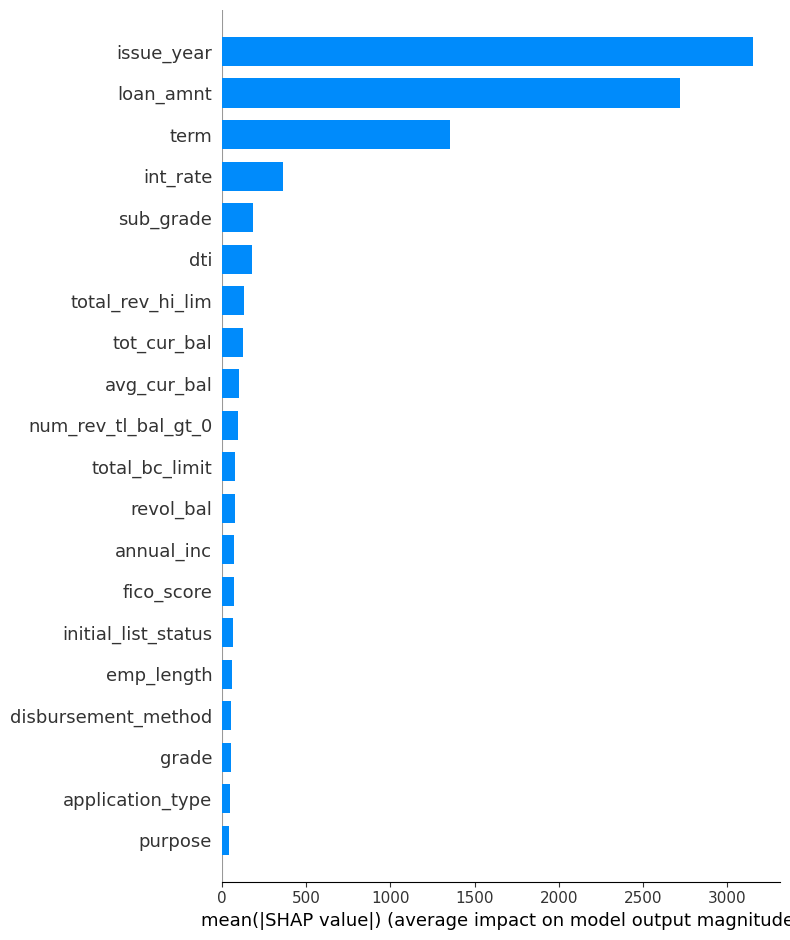

In [66]:
import shap

# SHAP sample
SHAP_SAMPLE_SIZE = 50_000
X_shap = X_train.sample(min(SHAP_SAMPLE_SIZE, len(X_train)), random_state=42).copy()

# Ensure categorical dtype
for c in cat_cols:
    if c in X_shap.columns:
        X_shap[c] = X_shap[c].astype("category")

# TreeExplainer
explainer = shap.TreeExplainer(lgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_shap)

# SHAP summary (beeswarm): direction + magnitude
plt.figure()
shap.summary_plot(shap_values, X_shap, max_display=20,show=True)

# SHAP feature importance - bar chart : mean absolute impact
plt.figure()
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=20, show=True)

Higher loan amounts, longer terms, and more recent issue years consistently increase predicted loss amounts, while borrower credit characteristics have moderate effects.


## Findings and recommendation

**Key Findings**
*   Loan amount and loan term are the strongest drivers of expected loss, with larger and longer-term loans consistently associated with higher predicted losses.

* The transition from linear baselines ($R^2 \approx 0.50$) to LightGBM ($R^2 \approx 0.66$) confirms that credit risk is driven by complex feature interactions such as the compounding effect of interest rates on high-principal loans

* Interest rate and credit quality contribute to loss severity, but have less impact than exposure-related features such as loan size and term.

* Income and DTI have limited direct influence on loss severity. Suggesting that capacity to pay is often secondary to total exposure in default scenarios.

* Issue year significantly impacts loss predictions, reflecting impact of changes in  macroeconomic conditions.


**Recommendations**

* Use expected loss as a core decision metric, rather than relying solely on default probability.

* Apply enhanced due diligence on high-exposure, long-term loans.

**Limitations and Next Steps**

* The model predicts loss severity but does not explicitly model probability of default.

* Post-origination borrower behavior is not available at application time, limiting predictive power.

* Future enhancements could include a joint Probability of default and Loss given default modelling and incorporation of macroeconomic factors.



